https://codenrock.com/contests/gpm-adtech-challenge#/

In [1]:
# !pip install catboost==1.2.3

In [2]:
# !pip install polars 

In [3]:
import re
import numpy as np
import pandas as pd
import catboost as cb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from pathlib import Path
from tqdm import tqdm

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.DataFrame.iteritems = pd.DataFrame.items
warnings.simplefilter('ignore')

__import__('warnings').filterwarnings("ignore")

DATASET_PATH = Path(r'G:\python-datasets\user_conversions')

if not DATASET_PATH.exists():
    DATASET_PATH = Path('.')
    __file__ = Path('.')
    LOCAL_FILE = ''
else:
    LOCAL_FILE = '_local'
    

DEBUG = True
DEBUG = False

if DEBUG: 
    n_rows = 50000
else: 
    n_rows = None
    
try:
    %load_ext autotime
except:
    pass    

time: 0 ns (started: 2024-03-26 18:36:58 +03:00)


In [4]:
cb.__version__

'1.2.3'

time: 0 ns (started: 2024-03-26 18:36:58 +03:00)


In [7]:
third_party_conversions = pd.read_parquet(DATASET_PATH.joinpath('third_party_conversions.parquet'))
third_party_conversions['time'] = pd.to_datetime(third_party_conversions['time'])

time: 25.4 s (started: 2024-03-24 12:22:15 +03:00)


In [8]:
# Сохраняем DataFrame в файл Parquet
# Укажите путь к файлу, куда вы хотите сохранить DataFrame
third_party_conversions_sample = DATASET_PATH.joinpath('third_party_conversions_sample.parquet')
# third_party_conversions.iloc[:60000].to_parquet(third_party_conversions_sample, engine='pyarrow')

time: 0 ns (started: 2024-03-24 12:22:40 +03:00)


In [9]:
third_party_conversions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3964826 entries, 0 to 3964825
Data columns (total 26 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   advertiser_id          int32         
 1   utm_source             object        
 2   search_engine          object        
 3   search_terms           object        
 4   user_segments          object        
 5   time                   datetime64[ns]
 6   region_code            object        
 7   city                   object        
 8   zip_code               object        
 9   isp_name               object        
 10  isp_type               float64       
 11  user_status            int32         
 12  user_id                object        
 13  user_detection_type    int32         
 14  ud_cookie_ts           object        
 15  accept_encoding        object        
 16  accept_language        object        
 17  ua_device_type         object        
 18  ua_os                 

In [10]:
# third_party_conversions = pl.read_parquet(
#     DATASET_PATH.joinpath('third_party_conversions.parquet'),
#     n_rows = None
# )
print(third_party_conversions.shape)
third_party_conversions.head(5)

(3964826, 26)


,advertiser_id,utm_source,search_engine,search_terms,user_segments,time,region_code,city,zip_code,isp_name,isp_type,user_status,user_id,user_detection_type,ud_cookie_ts,accept_encoding,accept_language,ua_device_type,ua_os,ua_browser,ua_third_party_cookie,ua_os_version,ua_browser_version,ua_parsing_type,ua_type,conversion_name
0,12453,yandex,None,None,"46370,8179,44985,16490,44589,52109,44128,44656...",2024-01-14 13:08:43,37,Shuya,155900,Beeline Home,0.0,1,u6pRVRhlWc17,1,2023-04-09 16:23:02,"gzip, deflate, br","ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7",SMARTPHONE,ANDROID,CHROME,True,10,119.0.0.0,0,3,10
1,12453,None,google,None,"44655,44985,43006,2177,44127,42940,1056,52967,...",2024-01-22 10:06:13,24,Krasnoyarsk,660000,CryptoCentre LLC,0.0,1,xSY4N4ZSevw,1,2023-08-29 03:58:37,"gzip, deflate, br","ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7",DESKTOP,WINDOWS,CHROME,True,10,120.0.0.0,0,1,pereyti
2,12453,None,google,None,"53604,53605,53606,53631",2024-01-12 09:56:05,77,Moskva,104015,OOO MVM,0.0,1,8qZ883xdhxx,1,2024-01-10 07:45:23,None,"ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7",DESKTOP,WINDOWS,CHROME,True,10,108.0.0.0,0,1,10
3,12453,yandex,None,None,"52966,44655,16490,44622,44589,1055,43896,44128...",2024-01-16 15:10:50,35,Kaduy,162510,Beeline Home,0.0,1,u5myOVNTm9Ts,1,2023-06-26 10:06:30,"gzip, deflate, br","ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7",SMARTPHONE,ANDROID,CHROME,True,10,120.0.0.0,0,3,implicit_depth_2
4,12453,yandex,None,None,"51415,51877,46371,11445,45151,45148,44884,4504...",2024-01-17 19:51:56,36,Voronezh,394000,Jsc Kvant-telekom,0.0,1,uscYneQ60ssX,1,2023-12-28 15:01:08,"gzip, deflate, br","ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7",SMARTPHONE,ANDROID,YANDEX,True,None,None,1,3,10


time: 31 ms (started: 2024-03-24 12:22:40 +03:00)


In [11]:
third_party_conversions.columns

Index(['advertiser_id', 'utm_source', 'search_engine', 'search_terms',
       'user_segments', 'time', 'region_code', 'city', 'zip_code', 'isp_name',
       'isp_type', 'user_status', 'user_id', 'user_detection_type',
       'ud_cookie_ts', 'accept_encoding', 'accept_language', 'ua_device_type',
       'ua_os', 'ua_browser', 'ua_third_party_cookie', 'ua_os_version',
       'ua_browser_version', 'ua_parsing_type', 'ua_type', 'conversion_name'],
      dtype='object')

time: 0 ns (started: 2024-03-24 12:22:40 +03:00)


In [12]:
third_party_conversions['conversion_name'].nunique()

15

time: 203 ms (started: 2024-03-24 12:22:40 +03:00)


In [13]:
third_party_conversions['conversion_name'].unique()

array(['10', 'pereyti', 'implicit_depth_2', '100', '200',
       'implicit_depth_3', 'implicit_depth_5', 'cart', 'spasibo',
       'oformlenie', 'dalee', 'dobavit', 'oplata', 'oformit_2',
       'oformit_1'], dtype=object)

time: 188 ms (started: 2024-03-24 12:22:41 +03:00)


In [14]:
third_party_conversions['user_id'].value_counts()

user_id
uLKLGaQ32bdL    2110
uBk7KUIDozW     1844
uxoXSsZxGdVM    1755
mg3SS5E6Q2      1637
xeAmRwk8JBO     1508
                ... 
ugawmXttwVba       1
8Sqwix2W4zx        1
uMLI3CM53v7p       1
6ejB4Cy3NC3        1
u88fXCjyGJxD       1
Name: count, Length: 1043414, dtype: int64

time: 1.3 s (started: 2024-03-24 12:22:41 +03:00)


In [15]:
conv_info = third_party_conversions.pivot_table(index='user_id', 
                                                values='ua_os', 
                                                columns='conversion_name', 
                                                aggfunc='count', fill_value=0)
conv_info.columns = [f'cn_{b}'.replace('implicit_depth_', 'dpt_') for b in conv_info.columns]
conv_info['total_count'] = conv_info.sum(axis=1)
conv_info.reset_index(inplace=True)
conv_info

,user_id,cn_10,cn_100,cn_200,cn_cart,cn_dalee,cn_dobavit,cn_dpt_2,cn_dpt_3,cn_dpt_5,cn_oformit_1,cn_oformit_2,cn_oformlenie,cn_oplata,cn_pereyti,cn_spasibo,total_count
0,0003ykdKZie,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,2
1,0005FCJbDbW,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0005wd0sf1P,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,0009gEbT09S,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,2
4,000CfOQHcAP,2,0,1,0,0,0,1,2,1,0,0,0,0,2,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043409,zzQZpLp6a9,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3
1043410,zzTBaBrtVM,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1043411,zzosMPTxzf,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,2
1043412,zzrRCRbJE0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2


time: 5.73 s (started: 2024-03-24 12:22:42 +03:00)


In [16]:
type(conv_info), isinstance(conv_info, pd.DataFrame), conv_info.size

(pandas.core.frame.DataFrame, True, 17738038)

time: 0 ns (started: 2024-03-24 12:22:48 +03:00)


In [17]:
tmp = third_party_conversions.isna().sum()
tmp

advertiser_id                  0
utm_source               2874785
search_engine            2254860
search_terms             3945620
user_segments             175433
time                           0
region_code               262050
city                      383931
zip_code                  424365
isp_name                   22463
isp_type                   21849
user_status                    0
user_id                        0
user_detection_type            0
ud_cookie_ts                   0
accept_encoding           204416
accept_language             8899
ua_device_type                 0
ua_os                          0
ua_browser                     0
ua_third_party_cookie          0
ua_os_version             116147
ua_browser_version         58525
ua_parsing_type                0
ua_type                        0
conversion_name                0
dtype: int64

time: 2.12 s (started: 2024-03-24 12:22:48 +03:00)


In [18]:
# Предлагаю эти колонки удалить, т.к. сильно много пропусков > 40%
tmp[tmp > third_party_conversions.shape[0] * 0.4]

utm_source       2874785
search_engine    2254860
search_terms     3945620
dtype: int64

time: 0 ns (started: 2024-03-24 12:22:50 +03:00)


In [5]:
train_views = pd.read_parquet(DATASET_PATH.joinpath('train_views.parquet'))
train_views['time'] = pd.to_datetime(train_views['time'])
print(train_views.shape)
train_views.head(5)

(1502904, 60)


,bid_url,bid_referer,bid_ip,bid_isp_name,landing_page,page_language,ssp_event_id,ssp,tag_id,publisher_id,creative_size,creative_type,battr,floor_cpm,visibility,carrier_id,model,mobile_screen_size,screen_pixel_ratio,is_https,ibv_blocked,is_interstitial,content_category,mime_types,content_tags,iframe_state,ads_txt_support,historical_viewability,gdpr_regulation,do_not_track,full_placement_id,user_fraud_state,is_mobile_optimized_site,device_screen,advertiser_id,creative_id,timezone_offset,utm_source,search_engine,search_terms,user_segments,time,region_code,city,zip_code,isp_type,user_id,user_detection_type,ud_cookie_ts,accept_encoding,accept_language,ua_device_type,ua_os,ua_browser,ua_third_party_cookie,ua_os_version,ua_browser_version,ua_parsing_type,ua_type,user_status
0,https://hd.23lordfilm-0.xyz,https://hd.23lordfilm-0.xyz/15515-odin-doma-b4...,7f7cae3961b13a171daba1d5f373b58e,Subnet LLC,https://incanto.eu/?utm_source=getintent&utm_m...,None,5friJXI0gxS,ohmybid,6ae23bce1c8c4e55,87,728x90,1,None,0.0001,UNKNOWN,subnet llc,None,None,0.0,True,False,False,iab24,None,"72,73",2,-2,NaN,-1,NaN,ohmybid_87_ukSIFYzf9eE_6ae23bce1c8c4e55,4,0.0,None,11527,657906,180.0,None,None,None,None,2024-01-05 10:52:57,5,Makhachkala,367000,0.0,None,0,None,None,None,DESKTOP,WINDOWS,YANDEX,True,10,23.11.0.0,0,1,11
1,https://hd.8lordserial.pro/277-pacany-3-sezon-...,https://hd.8lordserial.pro/277-pacany-3-sezon-...,5088e30457fb86e2db68ae6aba983d53,ER-Telecom,https://incanto.eu/?utm_source=getintent&utm_m...,None,xegyvF0fCt7,buzzoola,1217284,15747,300x250,1,None,11.0000,ABOVE,er-telecom,K,None,0.0,True,False,False,iab1-5,None,"72,73",2,-2,80.0,-1,NaN,buzzoola_15747_576552_1217284,4,NaN,None,11527,657909,420.0,None,None,None,None,2024-01-06 17:23:29,24,Krasnoyarsk,660000,0.0,None,0,None,None,None,SMARTPHONE,ANDROID,CHROME,True,10,120.0.0.0,0,1,11
2,https://schastlivyvmestetv.ru,None,3d563122099bdeba9c18cf39f64e29e9,Beeline Home,https://www.mvideo.ru/?utm_source=getintentdyn...,ru,QYMZhsIbgI,ohmybid,a8ac3391dabe31,90,300x250,1,None,24.3600,UNKNOWN,beeline home,None,None,0.0,True,False,False,iab24,None,72,2,-2,NaN,-1,NaN,ohmybid_90_6439_a8ac3391dabe31,2,0.0,None,12453,651855,180.0,None,None,None,"2094,42890,44763,42915,44349,42766,42974,42758...",2024-01-22 21:27:54,77,Moskva,104015,0.0,giJHLtcB3Oq,3,None,None,None,DESKTOP,WINDOWS,CHROME,True,10,109.0.0.0,0,1,1
3,https://drive2.ru/l/666115206383953104/,None,c3d678eab044b889e444d29f56674e06,Shark Telecom LLC,https://www.mvideo.ru/?utm_source=getintentdyn...,ru,5icvt0bMxNT,ohmybid,a11f3ad5b41c1200,88,300x600,1,None,19.0820,UNKNOWN,shark telecom llc,Desktop,None,0.0,True,False,False,iab2,None,72,2,-2,NaN,0,0.0,ohmybid_88_592940_a11f3ad5b41c1200,2,0.0,None,12453,651856,180.0,None,None,None,"44655,44820,16490,1055,16325,44128,52967,43895...",2024-01-20 10:10:45,77,Moskva,104015,0.0,uxWV5Ar8m4xR,3,None,None,None,DESKTOP,WINDOWS,OPERA,True,10,106.0.0.0,0,1,1
4,https://3-hd.lorfil.net/16685-8-podrug-oushena...,https://3-hd.lorfil.net/16685-8-podrug-oushena...,e31e1c1211aae15e91af5945611eb7d4,Moscow City Telephone Network,https://www.mvideo.ru/?utm_source=getintentdyn...,ru,5QcQe2TFB3y,skyadvert,None,1095,300x250,1,None,15.0000,ABOVE,moscow city telephone network,None,None,0.0,True,False,False,iab1-5,None,"72,73",0,-2,NaN,-1,NaN,skyadvert_1095_1979_300x250,2,NaN,None,12453,651855,180.0,None,None,None,"48085,44655,44985,44622,44589,44127,43896,5187...",2024-01-15 17:53:53,77,Moskva,104015,0.0,7tj3G3l2FDm,3,None,None,None,SMARTPHONE,ANDROID,CHROME,True,10,120.0.0.0,0,3,1


time: 9.53 s (started: 2024-03-26 18:37:10 +03:00)


In [6]:
train_views.duplicated().sum()

0

time: 5.97 s (started: 2024-03-26 18:37:23 +03:00)


In [21]:
# сколько user_id из train_views есть в third_party_conversions

both = set(train_views.user_id.unique()) & set(conv_info.user_id.unique())

print(f'train_views.user_id : {train_views.user_id.nunique():>7}')
print(f'third_party.user_id : {conv_info.user_id.nunique():>7}')
print(f'Пересечение множеств: {len(both):>7}')

train_views.user_id :  361608
third_party.user_id : 1043414
Пересечение множеств:   29656
time: 1.42 s (started: 2024-03-24 12:23:06 +03:00)


In [22]:
train_views[['content_tags']].head(7)

,content_tags
0,"72,73"
1,"72,73"
2,72
3,72
4,"72,73"
5,72
6,"72,73"


time: 15 ms (started: 2024-03-24 12:23:08 +03:00)


In [23]:
train_views.content_tags.unique()

array(['72,73', '72', '73'], dtype=object)

time: 62 ms (started: 2024-03-24 12:23:08 +03:00)


In [24]:
# разделение значений и преобразование их в бинарные метки
train_views[['ct72', 'ct73']] = train_views['content_tags'].str.get_dummies(',')
train_views[['content_tags', 'ct72', 'ct73']].head(7)

,content_tags,ct72,ct73
0,"72,73",1,1
1,"72,73",1,1
2,72,1,0
3,72,1,0
4,"72,73",1,1
5,72,1,0
6,"72,73",1,1


time: 3.08 s (started: 2024-03-24 12:23:08 +03:00)


In [27]:
train_views.content_category.nunique()

1870

time: 78 ms (started: 2024-03-24 12:24:27 +03:00)


In [32]:
train_views.content_category.head(10)

0          iab24
1         iab1-5
2          iab24
3           iab2
4         iab1-5
5          iab12
6    iab1,iab1-5
7          iab12
8         iab1-5
9          iab24
Name: content_category, dtype: object

time: 0 ns (started: 2024-03-24 12:25:19 +03:00)


In [33]:
train_views.content_category.unique()[:20]

array(['iab24', 'iab1-5', 'iab2', 'iab12', 'iab1,iab1-5', 'iab19', 'iab9',
       'iab5-6,iab5', 'iab1-7,iab1', 'iab17', 'iab1-1', 'iab18', 'iab1',
       'iab9-30', 'iab1,iab25,iab3,iab24,iab2,iab26,iab9',
       'iab18-3, iab1-2,iab14, iab18, iab12, iab9, iab1',
       'iab12-2, iab12-3,iab12', 'iab1,iab1-1', 'iab13',
       'iab18,iab1,iab14,iab5,iab7,iab6,iab12,iab9'], dtype=object)

time: 78 ms (started: 2024-03-24 12:27:04 +03:00)


In [43]:
train_views['content_category'].fillna('', inplace=True)
train_views['content_category'] = train_views['content_category'].str.replace(' ', '')

time: 359 ms (started: 2024-03-24 12:37:43 +03:00)


In [46]:
tqdm.pandas()
train_views.content_category = train_views.content_category.progress_apply(
    lambda x: '' if pd.isna(x) else ' '.join(sorted(x.split(','))))

100%|████████████████████████████████████████████████████████████████████| 1502904/1502904 [00:01<00:00, 763199.12it/s]

time: 1.98 s (started: 2024-03-24 12:38:13 +03:00)


In [47]:
# Разделяем категории и создаем список уникальных категорий
all_categories = set()
train_views['content_category'].fillna('').str.split(' ').apply(all_categories.update)

0          None
1          None
2          None
3          None
4          None
           ... 
1502899    None
1502900    None
1502901    None
1502902    None
1502903    None
Name: content_category, Length: 1502904, dtype: object

time: 1.78 s (started: 2024-03-24 12:38:18 +03:00)


In [50]:
all_categories

{'4hdkao6q',
 'iab1',
 'iab1-1',
 'iab1-2',
 'iab1-3',
 'iab1-4',
 'iab1-5',
 'iab1-6',
 'iab1-7',
 'iab10',
 'iab10-1',
 'iab10-2',
 'iab10-3',
 'iab10-4',
 'iab10-5',
 'iab10-6',
 'iab10-7',
 'iab10-8',
 'iab10-9',
 'iab11',
 'iab11-2',
 'iab11-4',
 'iab11-5',
 'iab12',
 'iab12-1',
 'iab12-2',
 'iab12-3',
 'iab13',
 'iab13-1',
 'iab13-11',
 'iab13-3',
 'iab13-4',
 'iab13-7',
 'iab13-8',
 'iab14',
 'iab14-1',
 'iab14-7',
 'iab14-ws1',
 'iab15',
 'iab15-1',
 'iab15-10',
 'iab15-2',
 'iab15-3',
 'iab15-8',
 'iab15-9',
 'iab16',
 'iab16-1',
 'iab16-2',
 'iab16-3',
 'iab16-4',
 'iab16-5',
 'iab16-6',
 'iab17',
 'iab17-10',
 'iab17-12',
 'iab17-13',
 'iab17-18',
 'iab17-20',
 'iab17-26',
 'iab17-27',
 'iab17-39',
 'iab17-4',
 'iab17-40',
 'iab17-44',
 'iab18',
 'iab18-1',
 'iab18-3',
 'iab18-4',
 'iab18-5',
 'iab18-6',
 'iab19',
 'iab19-1',
 'iab19-10',
 'iab19-14',
 'iab19-17',
 'iab19-18',
 'iab19-19',
 'iab19-2',
 'iab19-20',
 'iab19-22',
 'iab19-27',
 'iab19-29',
 'iab19-30',
 'iab19-5

time: 16 ms (started: 2024-03-24 12:43:04 +03:00)


In [51]:
len(all_categories)

195

time: 0 ns (started: 2024-03-24 12:43:06 +03:00)


In [52]:
new_all_categories = set([item.split('-')[0] for item in all_categories])

time: 15 ms (started: 2024-03-24 15:43:44 +03:00)


In [54]:
# '4hdkao6q' категорию можно выкинуть, т.к. её нет у юзеров с меткой "1", всего 4 записи с такой категорией
len(new_all_categories), new_all_categories

(27,
 {'4hdkao6q',
  'iab1',
  'iab10',
  'iab11',
  'iab12',
  'iab13',
  'iab14',
  'iab15',
  'iab16',
  'iab17',
  'iab18',
  'iab19',
  'iab2',
  'iab20',
  'iab21',
  'iab22',
  'iab23',
  'iab24',
  'iab25',
  'iab26',
  'iab3',
  'iab4',
  'iab5',
  'iab6',
  'iab7',
  'iab8',
  'iab9'})

time: 15 ms (started: 2024-03-24 15:44:09 +03:00)


In [72]:
train_views[train_views.content_category.str.contains('4hdkao6q')]

,bid_url,bid_referer,bid_ip,bid_isp_name,landing_page,page_language,ssp_event_id,ssp,tag_id,publisher_id,creative_size,creative_type,battr,floor_cpm,visibility,carrier_id,model,mobile_screen_size,screen_pixel_ratio,is_https,ibv_blocked,is_interstitial,content_category,mime_types,content_tags,iframe_state,ads_txt_support,historical_viewability,gdpr_regulation,do_not_track,full_placement_id,user_fraud_state,is_mobile_optimized_site,device_screen,advertiser_id,creative_id,timezone_offset,utm_source,search_engine,search_terms,user_segments,time,region_code,city,zip_code,isp_type,user_id,user_detection_type,ud_cookie_ts,accept_encoding,accept_language,ua_device_type,ua_os,ua_browser,ua_third_party_cookie,ua_os_version,ua_browser_version,ua_parsing_type,ua_type,user_status,ct72,ct73,time_diff
143380,https://rostoumama.ru/11-uhod-za-zhirnoy-kozhe...,https://rostoumama.ru/11-uhod-za-zhirnoy-kozhe...,de81545424d7ea8fcb081750f7c470e1,Yota,https://incanto.eu/?utm_source=getintent&utm_m...,ru,uevwpiDOaMae,moevideo,None,881,300x250,1,None,23.0,UNKNOWN,yota,None,None,0.0,True,False,False,4hdkao6q iab18-1 iab7-32 iab7-37 iab7-44 iab7-45,None,"72,73",2,-2,NaN,-1,0.0,moevideo_881_31450_300x250,2,NaN,None,11527,657904,180.0,None,None,None,39804,2024-01-08 23:21:24,77,Moskva,104015,0.0,LyREoZ16qez,3,NaT,None,None,SMARTPHONE,ANDROID,CHROME,True,11,110.0.0.0,0,3,1,1,1,-999
1140964,https://rostoumama.ru/73-modnye-strizhki-s-zad...,https://rostoumama.ru/73-modnye-strizhki-s-zad...,d5bcc09537520adc3e45fbda15fd0700,Yota,https://incanto.eu/?utm_source=getintent&utm_m...,ru,77JMKyf0Ahe,moevideo,None,881,300x250,1,None,33.0,UNKNOWN,yota,None,None,0.0,True,False,False,4hdkao6q iab18-1 iab7-32 iab7-37 iab7-44 iab7-45,None,"72,73",2,-2,NaN,-1,0.0,moevideo_881_31450_300x250,2,NaN,None,11527,657909,180.0,None,None,None,"52420,51774,39804,52421,52305",2024-01-08 21:54:12,77,Moskva,104015,0.0,ugQckUNxRnyq,3,NaT,None,None,SMARTPHONE,ANDROID,CHROME,True,11,110.0.0.0,0,3,1,1,1,-999
1245136,https://rostoumama.ru/215-vash-rebenok-levsha....,https://rostoumama.ru/215-vash-rebenok-levsha....,ebbd1a26fd102b513b7f50a00a485ab9,PJSC MegaFon,https://incanto.eu/?utm_source=getintent&utm_m...,ru,PTymEY6az0l,moevideo,None,881,300x250,1,None,13.0,UNKNOWN,pjsc megafon,None,None,0.0,True,False,False,4hdkao6q iab18-1 iab7-32 iab7-37 iab7-44 iab7-45,None,"72,73",2,-2,NaN,-1,0.0,moevideo_881_31450_300x250,2,NaN,None,11527,657909,180.0,None,None,None,39804,2024-01-08 12:27:28,77,Moskva,104015,0.0,uPCCxFsXSmG5,3,NaT,None,None,SMARTPHONE,ANDROID,CHROME,True,11,110.0.0.0,0,3,1,1,1,-999
1483702,https://rostoumama.ru/141-seks-tur-na-domu.-in...,https://rostoumama.ru/141-seks-tur-na-domu.-in...,de81545424d7ea8fcb081750f7c470e1,Yota,https://incanto.eu/?utm_source=getintent&utm_m...,ru,u7kkCtdc2tre,moevideo,None,881,300x250,1,None,23.0,UNKNOWN,yota,None,None,0.0,True,False,False,4hdkao6q iab18-1 iab7-32 iab7-37 iab7-44 iab7-45,None,"72,73",2,-2,NaN,-1,0.0,moevideo_881_31450_300x250,2,NaN,None,11527,657909,180.0,None,None,None,None,2024-01-08 23:26:53,77,Moskva,104015,0.0,q8sr5knDLX,3,NaT,None,None,SMARTPHONE,ANDROID,CHROME,True,12,111.0.0.0,0,3,1,1,1,-999


time: 547 ms (started: 2024-03-24 15:54:34 +03:00)


In [58]:
train_views[train_views.content_category.str.contains('4hdkao6q')].user_id.values

array(['LyREoZ16qez', 'ugQckUNxRnyq', 'uPCCxFsXSmG5', 'q8sr5knDLX'],
      dtype=object)

time: 593 ms (started: 2024-03-24 15:47:52 +03:00)


In [25]:
grp = train_views.groupby('city').agg(zip_uniq=('zip_code', pd.Series.nunique))
grp

,zip_uniq
city,
Abakan,14
Aban,1
Abatskoye,1
Abaza,2
Abinsk,1
...,...
Zubtsov,1
Zudilovo,1
Zuyevka,1


time: 328 ms (started: 2024-03-24 12:23:11 +03:00)


In [21]:
grp[grp.zip_uniq>1]

,zip_uniq
city,
Abakan,12
Achinsk,2
Al'met'evsk,3
Aleksandrov,2
Anapa,4
...,...
Yekaterinburg,39
Yoshkar-ola,11
Zheleznogorsk,3


In [22]:
# посмотреть какой это тип и преобразовать в int или float
train_views.historical_viewability.unique()

array([ nan,  80.,  96.,  92.,  66.,  79.,  86.,  69.,  76.,  78.,  48.,
        75.,  68.,  43.,  74.,  28.,  67.,  71.,  88.,  94.,  91.,  72.,
        73.,  53.,  50.,  22.,  93.,  37.,  17.,  30.,  97.,  55.,  51.,
        85.,  82.,  90.,  70.,  23.,  83.,   2.,  77.,  33.,  98.,  59.,
        95.,   0.,  81.,  11.,   8.,  54.,  87., 100.,  89.,  60.,  32.,
        84.,  58.,  45.,  65.,  46.,  36.,  31.,   7.,  25.,  61.,  47.,
        15.,  12.,  64.,   6.,  24.,  13.,  52.,   9.,  63.,  19.,   4.,
        21.,  44.,  40.,  99.,  42.,   1.,  29.,  39.,   5.,  34.,  14.,
        56.,  27.,  35.,  16.,   3.,  38.,  57.,  18.,  49.,  20.,  41.,
        26.,  62.,  10.])

In [23]:
train_views.isp_type.unique()

array([ 0., nan,  1.])

In [59]:
# преобразование в формат datetime
train_views['time'] = pd.to_datetime(train_views['time'])
train_views['ud_cookie_ts'] = pd.to_datetime(train_views['ud_cookie_ts'])

# вычисление разницы в секундах
train_views['time_diff'] = (train_views['time'] - train_views['ud_cookie_ts']).dt.total_seconds()
train_views['time_diff'] = train_views['time_diff'].fillna(-999).astype(int)
train_views.head(7)

,bid_url,bid_referer,bid_ip,bid_isp_name,landing_page,page_language,ssp_event_id,ssp,tag_id,publisher_id,creative_size,creative_type,battr,floor_cpm,visibility,carrier_id,model,mobile_screen_size,screen_pixel_ratio,is_https,ibv_blocked,is_interstitial,content_category,mime_types,content_tags,iframe_state,ads_txt_support,historical_viewability,gdpr_regulation,do_not_track,full_placement_id,user_fraud_state,is_mobile_optimized_site,device_screen,advertiser_id,creative_id,timezone_offset,utm_source,search_engine,search_terms,user_segments,time,region_code,city,zip_code,isp_type,user_id,user_detection_type,ud_cookie_ts,accept_encoding,accept_language,ua_device_type,ua_os,ua_browser,ua_third_party_cookie,ua_os_version,ua_browser_version,ua_parsing_type,ua_type,user_status,ct72,ct73,time_diff
0,https://hd.23lordfilm-0.xyz,https://hd.23lordfilm-0.xyz/15515-odin-doma-b4...,7f7cae3961b13a171daba1d5f373b58e,Subnet LLC,https://incanto.eu/?utm_source=getintent&utm_m...,None,5friJXI0gxS,ohmybid,6ae23bce1c8c4e55,87,728x90,1,None,0.000100,UNKNOWN,subnet llc,None,None,0.0,True,False,False,iab24,None,"72,73",2,-2,NaN,-1,NaN,ohmybid_87_ukSIFYzf9eE_6ae23bce1c8c4e55,4,0.0,None,11527,657906,180.0,None,None,None,None,2024-01-05 10:52:57,5,Makhachkala,367000,0.0,None,0,NaT,None,None,DESKTOP,WINDOWS,YANDEX,True,10,23.11.0.0,0,1,11,1,1,-999
1,https://hd.8lordserial.pro/277-pacany-3-sezon-...,https://hd.8lordserial.pro/277-pacany-3-sezon-...,5088e30457fb86e2db68ae6aba983d53,ER-Telecom,https://incanto.eu/?utm_source=getintent&utm_m...,None,xegyvF0fCt7,buzzoola,1217284,15747,300x250,1,None,11.000000,ABOVE,er-telecom,K,None,0.0,True,False,False,iab1-5,None,"72,73",2,-2,80.0,-1,NaN,buzzoola_15747_576552_1217284,4,NaN,None,11527,657909,420.0,None,None,None,None,2024-01-06 17:23:29,24,Krasnoyarsk,660000,0.0,None,0,NaT,None,None,SMARTPHONE,ANDROID,CHROME,True,10,120.0.0.0,0,1,11,1,1,-999
2,https://schastlivyvmestetv.ru,None,3d563122099bdeba9c18cf39f64e29e9,Beeline Home,https://www.mvideo.ru/?utm_source=getintentdyn...,ru,QYMZhsIbgI,ohmybid,a8ac3391dabe31,90,300x250,1,None,24.360000,UNKNOWN,beeline home,None,None,0.0,True,False,False,iab24,None,72,2,-2,NaN,-1,NaN,ohmybid_90_6439_a8ac3391dabe31,2,0.0,None,12453,651855,180.0,None,None,None,"2094,42890,44763,42915,44349,42766,42974,42758...",2024-01-22 21:27:54,77,Moskva,104015,0.0,giJHLtcB3Oq,3,NaT,None,None,DESKTOP,WINDOWS,CHROME,True,10,109.0.0.0,0,1,1,1,0,-999
3,https://drive2.ru/l/666115206383953104/,None,c3d678eab044b889e444d29f56674e06,Shark Telecom LLC,https://www.mvideo.ru/?utm_source=getintentdyn...,ru,5icvt0bMxNT,ohmybid,a11f3ad5b41c1200,88,300x600,1,None,19.082000,UNKNOWN,shark telecom llc,Desktop,None,0.0,True,False,False,iab2,None,72,2,-2,NaN,0,0.0,ohmybid_88_592940_a11f3ad5b41c1200,2,0.0,None,12453,651856,180.0,None,None,None,"44655,44820,16490,1055,16325,44128,52967,43895...",2024-01-20 10:10:45,77,Moskva,104015,0.0,uxWV5Ar8m4xR,3,NaT,None,None,DESKTOP,WINDOWS,OPERA,True,10,106.0.0.0,0,1,1,1,0,-999
4,https://3-hd.lorfil.net/16685-8-podrug-oushena...,https://3-hd.lorfil.net/16685-8-podrug-oushena...,e31e1c1211aae15e91af5945611eb7d4,Moscow City Telephone Network,https://www.mvideo.ru/?utm_source=getintentdyn...,ru,5QcQe2TFB3y,skyadvert,None,1095,300x250,1,None,15.000000,ABOVE,moscow city telephone network,None,None,0.0,True,False,False,iab1-5,None,"72,73",0,-2,NaN,-1,NaN,skyadvert_1095_1979_300x250,2,NaN,None,12453,651855,180.0,None,None,None,"48085,44655,44985,44622,44589,44127,43896,5187...",2024-01-15 17:53:53,77,Moskva,104015,0.0,7tj3G3l2FDm,3,NaT,None,None,SMARTPHONE,ANDROID,CHROME,True,10,120.0.0.0,0,3,1,1,1,-999
5,https://hd.lordserials.wine/drama/21353-ubijcy...,None,d9060c115a9ed60efde92357a972dfe9,Skynet,https://incanto.eu/?utm_source=getintent&utm_m...,None,u6taphfrJDmf,otm_display,54688,5937c422f0b37c7566937953,300x250,1,None,1.428571,UNKNOWN,skynet,None,None,0.0,True,False,False,iab12,None,72,2,-2,NaN,-1,NaN,otm_display_5937c422f0b37c7566937953_10306_54688,2,NaN,None,11527,657909,180.0,

time: 437 ms (started: 2024-03-24 15:48:05 +03:00)


In [25]:
train_views[train_views['time_diff']>-1].time_diff.min(), train_views.time_diff.max()

(0, 31503446)

In [26]:
cat_features = list(train_views.columns[train_views.dtypes == 'object'])
num_features = list(train_views.columns[~(train_views.dtypes == 'object')])

cat_features = [f for f in cat_features if f not in ['label', 'time']]
num_features = [f for f in num_features if f not in ['label', 'time']]
num_features

['creative_type',
 'floor_cpm',
 'screen_pixel_ratio',
 'is_https',
 'ibv_blocked',
 'is_interstitial',
 'iframe_state',
 'ads_txt_support',
 'historical_viewability',
 'gdpr_regulation',
 'do_not_track',
 'user_fraud_state',
 'is_mobile_optimized_site',
 'advertiser_id',
 'creative_id',
 'timezone_offset',
 'isp_type',
 'user_detection_type',
 'ud_cookie_ts',
 'ua_third_party_cookie',
 'ua_parsing_type',
 'ua_type',
 'user_status',
 'ct72',
 'ct73',
 'time_diff']

In [27]:
for col in num_features:
    print(f'признак: {col}, уникальных значений: {train_views[col].nunique()}')

признак: creative_type, уникальных значений: 2
признак: floor_cpm, уникальных значений: 1794
признак: screen_pixel_ratio, уникальных значений: 2
признак: is_https, уникальных значений: 2
признак: ibv_blocked, уникальных значений: 2
признак: is_interstitial, уникальных значений: 2
признак: iframe_state, уникальных значений: 2
признак: ads_txt_support, уникальных значений: 5
признак: historical_viewability, уникальных значений: 101
признак: gdpr_regulation, уникальных значений: 3
признак: do_not_track, уникальных значений: 2
признак: user_fraud_state, уникальных значений: 2
признак: is_mobile_optimized_site, уникальных значений: 2
признак: advertiser_id, уникальных значений: 2
признак: creative_id, уникальных значений: 233
признак: timezone_offset, уникальных значений: 11
признак: isp_type, уникальных значений: 2
признак: user_detection_type, уникальных значений: 3
признак: ud_cookie_ts, уникальных значений: 3831
признак: ua_third_party_cookie, уникальных значений: 2
признак: ua_parsing_

In [28]:
new_cat_features = ['ads_txt_support', 'gdpr_regulation', 'user_fraud_state', 'creative_id',
                    'user_detection_type', 'ua_type', 'user_status']

for col in new_cat_features:
    print(f'признак: {col}, уникальных значений: {train_views[col].unique()}')

признак: ads_txt_support, уникальных значений: [-2  1  0  2  3]
признак: gdpr_regulation, уникальных значений: [-1  0  1]
признак: user_fraud_state, уникальных значений: [4 2]
признак: creative_id, уникальных значений: [657906 657909 651855 651856 657911 657699 657908 657659 657661 657654
 657597 657564 657749 657706 657543 651853 657541 657577 657689 657904
 657688 657639 651849 657553 657907 657594 657514 657529 657725 657501
 657677 657530 657605 657522 657657 651854 657625 657655 657589 657680
 657628 657540 661498 657629 657565 657599 657643 657583 657634 657508
 657506 651852 657617 657619 657578 657751 651857 657635 657910 657590
 657702 657549 657684 657705 657905 657648 657666 657600 657694 657645
 657552 657574 657746 657724 657588 657640 657708 657503 657735 657585
 661514 657641 657686 657742 657741 657558 657715 657520 657601 657573
 657714 657731 657621 657521 657496 657526 657559 657679 657750 657658
 657653 657664 657669 657512 657603 657567 657505 657542 657555 657516


In [29]:
train_views.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 63 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   bid_url                   50000 non-null  object        
 1   bid_referer               10985 non-null  object        
 2   bid_ip                    50000 non-null  object        
 3   bid_isp_name              49846 non-null  object        
 4   landing_page              50000 non-null  object        
 5   page_language             23034 non-null  object        
 6   ssp_event_id              50000 non-null  object        
 7   ssp                       50000 non-null  object        
 8   tag_id                    46105 non-null  object        
 9   publisher_id              48913 non-null  object        
 10  creative_size             50000 non-null  object        
 11  creative_type             50000 non-null  int32         
 12  battr             

In [30]:
# столбцы, по которым можно определить юзера
fields = ['bid_ip', 'carrier_id', 'model', 'region_code', 'city', 'zip_code',
          'ua_device_type', 'ua_os', 'ua_browser', 'ua_os_version', 'ua_browser_version']

tmp = train_views[fields].isna().sum()
tmp

bid_ip                    0
carrier_id              772
model                 24022
region_code            1098
city                   1780
zip_code               1936
ua_device_type            0
ua_os                     0
ua_browser                0
ua_os_version           810
ua_browser_version      275
dtype: int64

In [31]:
tmp = train_views.isna().sum()
tmp

bid_url                         0
bid_referer                 39015
bid_ip                          0
bid_isp_name                  154
landing_page                    0
page_language               26966
ssp_event_id                    0
ssp                             0
tag_id                       3895
publisher_id                 1087
creative_size                   0
creative_type                   0
battr                       49974
floor_cpm                       0
visibility                      0
carrier_id                    772
model                       24022
mobile_screen_size          45808
screen_pixel_ratio              0
is_https                        0
ibv_blocked                     0
is_interstitial                 0
content_category                0
mime_types                  46951
content_tags                    0
iframe_state                    0
ads_txt_support                 0
historical_viewability      29596
gdpr_regulation                 0
do_not_track  

In [32]:
train_views.user_id.nunique(), third_party_conversions.user_id.nunique()

(22232, 49281)

In [33]:
# Предлагаю эти колонки удалить, т.к. сильно много пропусков > 40%
tmp[tmp > train_views.shape[0] * 0.4]

bid_referer                 39015
page_language               26966
battr                       49974
model                       24022
mobile_screen_size          45808
mime_types                  46951
historical_viewability      29596
do_not_track                43127
is_mobile_optimized_site    40225
device_screen               45808
utm_source                  49995
search_engine               49934
search_terms                49991
ud_cookie_ts                45281
accept_encoding             44501
accept_language             44504
dtype: int64

In [34]:
# список полей с большим кол-вом пропусков
outlets = tmp[tmp > train_views.shape[0] * 0.4].index
outlets

Index(['bid_referer', 'page_language', 'battr', 'model', 'mobile_screen_size',
       'mime_types', 'historical_viewability', 'do_not_track',
       'is_mobile_optimized_site', 'device_screen', 'utm_source',
       'search_engine', 'search_terms', 'ud_cookie_ts', 'accept_encoding',
       'accept_language'],
      dtype='object')

In [35]:
for col in outlets:
    print(f'колонка: {col} количество уникальных значений {train_views[col].nunique()}')

колонка: bid_referer количество уникальных значений 6416
колонка: page_language количество уникальных значений 7
колонка: battr количество уникальных значений 4
колонка: model количество уникальных значений 1265
колонка: mobile_screen_size количество уникальных значений 1221
колонка: mime_types количество уникальных значений 4
колонка: historical_viewability количество уникальных значений 101
колонка: do_not_track количество уникальных значений 2
колонка: is_mobile_optimized_site количество уникальных значений 2
колонка: device_screen количество уникальных значений 1221
колонка: utm_source количество уникальных значений 4
колонка: search_engine количество уникальных значений 2
колонка: search_terms количество уникальных значений 9
колонка: ud_cookie_ts количество уникальных значений 3831
колонка: accept_encoding количество уникальных значений 7
колонка: accept_language количество уникальных значений 187


In [36]:
train_views.time.min(), train_views.time.max()

(Timestamp('2024-01-02 21:00:03'), Timestamp('2024-01-23 23:59:32'))

In [37]:
# в каких данных есть пропуски для пропущенных user_id

train_views[train_views.user_id.isna()].isna().sum()

bid_url                         0
bid_referer                 11368
bid_ip                          0
bid_isp_name                   60
landing_page                    0
page_language               11578
ssp_event_id                    0
ssp                             0
tag_id                        416
publisher_id                   18
creative_size                   0
creative_type                   0
battr                       16495
floor_cpm                       0
visibility                      0
carrier_id                    151
model                       12308
mobile_screen_size          15887
screen_pixel_ratio              0
is_https                        0
ibv_blocked                     0
is_interstitial                 0
content_category                0
mime_types                  16333
content_tags                    0
iframe_state                    0
ads_txt_support                 0
historical_viewability      13031
gdpr_regulation                 0
do_not_track  

In [7]:
train_actions = pd.read_parquet(DATASET_PATH.joinpath('train_actions.parquet'))
train_actions['time'] = pd.to_datetime(train_actions['time'])
print(train_actions.shape)
train_actions.head(5)

(644856, 6)


,time,ssp_event_id,clicks,conversion_name,is_post_click,is_post_view
0,2024-01-02 21:36:50,uxxLGVvM1aOs,0,pereyti,1,0
1,2024-01-02 21:08:31,M9no149TZAc,0,pereyti,1,0
2,2024-01-02 21:23:01,xY4srE5hee8,0,pereyti,1,0
3,2024-01-02 21:28:09,0gcd7iQx2H9,0,pereyti,1,0
4,2024-01-02 21:06:44,s0snGGmhlNa,0,pereyti,1,0


time: 469 ms (started: 2024-03-26 18:39:06 +03:00)


In [8]:
train_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 644856 entries, 0 to 644855
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   time             644856 non-null  datetime64[ns]
 1   ssp_event_id     644856 non-null  object        
 2   clicks           644856 non-null  int32         
 3   conversion_name  644856 non-null  object        
 4   is_post_click    644856 non-null  int64         
 5   is_post_view     644856 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(2), object(2)
memory usage: 27.1+ MB
time: 47 ms (started: 2024-03-26 18:39:09 +03:00)


In [9]:
train_actions.columns

Index(['time', 'ssp_event_id', 'clicks', 'conversion_name', 'is_post_click',
       'is_post_view'],
      dtype='object')

time: 0 ns (started: 2024-03-26 18:39:10 +03:00)


In [10]:
tmp = train_actions.isna().sum()
tmp

time               0
ssp_event_id       0
clicks             0
conversion_name    0
is_post_click      0
is_post_view       0
dtype: int64

time: 31 ms (started: 2024-03-26 18:39:13 +03:00)


In [11]:
train_actions.is_post_click.value_counts()

is_post_click
0    614959
1     29897
Name: count, dtype: int64

time: 15 ms (started: 2024-03-26 18:39:15 +03:00)


In [11]:
train_actions['conversion_name'].nunique()

15

time: 31 ms (started: 2024-03-23 21:51:23 +03:00)


In [12]:
train_actions.conversion_name.value_counts()

conversion_name
10                  188169
implicit_depth_2    154757
implicit_depth_3     79726
100                  74211
pereyti              64607
200                  42702
implicit_depth_5     18116
cart                  9780
oformlenie            5381
dobavit               3266
dalee                 2270
spasibo                851
oformit_1              469
oplata                 403
oformit_2              148
Name: count, dtype: int64

time: 15 ms (started: 2024-03-23 21:51:25 +03:00)


In [13]:
train_views.duplicated().sum()

0

time: 6.67 s (started: 2024-03-23 21:51:27 +03:00)


In [14]:
train_views.shape[0], train_actions.shape[0]

(1502904, 644856)

time: 0 ns (started: 2024-03-23 21:51:36 +03:00)


In [15]:
train_views.ssp_event_id.value_counts()

ssp_event_id
u60R6nMXDTyb    4
e8bxHXywy34     4
ex4dGf3sYXK     4
eRECqvAhyTX     4
u8ABD03QaQTy    4
               ..
uPbrelApgkUq    1
u5XjFeDLbWmf    1
0mOfVW9o7qV     1
7AlYUfnI7f7     1
eE7AzOd01CG     1
Name: count, Length: 1502746, dtype: int64

time: 1.31 s (started: 2024-03-23 21:51:39 +03:00)


In [19]:
train_views.loc[train_views.ssp_event_id=='u8ABD03QaQTy','user_segments']

228460     48085,44655,52966,18667,42940,44128,46371,1853...
310014     48085,44655,44622,52966,18667,42940,44128,4033...
347363     48085,44655,44622,52966,18667,42940,44128,4033...
1043688    48085,44655,44622,52966,18667,42940,44128,4033...
Name: user_segments, dtype: object

time: 109 ms (started: 2024-03-23 21:52:38 +03:00)


## ssp_event_id вроде должен быть уникальным???

In [20]:
train_views[train_views.ssp_event_id=='u8ABD03QaQTy']

,bid_url,bid_referer,bid_ip,bid_isp_name,landing_page,page_language,ssp_event_id,ssp,tag_id,publisher_id,creative_size,creative_type,battr,floor_cpm,visibility,carrier_id,model,mobile_screen_size,screen_pixel_ratio,is_https,ibv_blocked,is_interstitial,content_category,mime_types,content_tags,iframe_state,ads_txt_support,historical_viewability,gdpr_regulation,do_not_track,full_placement_id,user_fraud_state,is_mobile_optimized_site,device_screen,advertiser_id,creative_id,timezone_offset,utm_source,search_engine,search_terms,user_segments,time,region_code,city,zip_code,isp_type,user_id,user_detection_type,ud_cookie_ts,accept_encoding,accept_language,ua_device_type,ua_os,ua_browser,ua_third_party_cookie,ua_os_version,ua_browser_version,ua_parsing_type,ua_type,user_status,time_diff
228460,https://greyanatomy.ru/seasons/season-11/episo...,None,2c315d206c2bc89687d5f4fe7141acfc,Tele.RU Ltd.,https://www.mvideo.ru/?utm_source=getintentdyn...,ru,u8ABD03QaQTy,adlook,23808,7239,300x250,1,None,4.0,UNKNOWN,tele.ru ltd.,generic smartphone,None,0.0,True,False,False,iab6-1,None,"72,73",2,-2,NaN,-1,NaN,adlook_7239_9936_23808,2,NaN,None,12453,651855,180.0,None,None,None,"48085,44655,52966,18667,42940,44128,46371,1853...",2024-01-23 03:02:26,77,Moskva,104015,0.0,u7loY2hA5f02,1,2023-10-23 14:14:46,"gzip, deflate, br","ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7",SMARTPHONE,ANDROID,CHROME,True,10,120.0.0.0,0,3,1,7908460
310014,https://greyanatomy.ru/seasons/season-11/episo...,None,2c315d206c2bc89687d5f4fe7141acfc,Tele.RU Ltd.,https://www.mvideo.ru/?utm_source=getintentdyn...,ru,u8ABD03QaQTy,adlook,23808,7239,300x250,1,None,3.0,UNKNOWN,tele.ru ltd.,generic smartphone,None,0.0,True,False,False,iab6-1,None,"72,73",2,-2,NaN,-1,NaN,adlook_7239_9936_23808,2,NaN,None,12453,651855,180.0,None,None,None,"48085,44655,44622,52966,18667,42940,44128,4033...",2024-01-23 03:02:19,77,Moskva,104015,0.0,u7loY2hA5f02,1,2023-10-23 14:14:46,"gzip, deflate, br","ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7",SMARTPHONE,ANDROID,CHROME,True,10,120.0.0.0,0,3,1,7908453
347363,https://greyanatomy.ru/seasons/season-11/episo...,None,2c315d206c2bc89687d5f4fe7141acfc,Tele.RU Ltd.,https://www.mvideo.ru/?utm_source=getintentdyn...,ru,u8ABD03QaQTy,adlook,23808,7239,300x250,1,None,3.0,UNKNOWN,tele.ru ltd.,generic smartphone,None,0.0,True,False,False,iab6-1,None,"72,73",2,-2,NaN,-1,NaN,adlook_7239_9936_23808,2,NaN,None,12453,651855,180.0,None,None,None,"48085,44655,44622,52966,18667,42940,44128,4033...",2024-01-23 03:02:04,77,Moskva,104015,0.0,u7loY2hA5f02,1,2023-10-23 14:14:46,"gzip, deflate, br","ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7",SMARTPHONE,ANDROID,CHROME,True,10,120.0.0.0,0,3,1,7908438
1043688,https://greyanatomy.ru/seasons/season-11/episo...,None,2c315d206c2bc89687d5f4fe7141acfc,Tele.RU Ltd.,https://www.mvideo.ru/?utm_source=getintentdyn...,ru,u8ABD03QaQTy,adlook,23808,7239,300x250,1,None,4.0,UNKNOWN,tele.ru ltd.,generic smartphone,None,0.0,True,False,False,iab6-1,None,"72,73",2,-2,NaN,-1,NaN,adlook_7239_9936_23808,2,NaN,None,12453,651855,180.0,None,None,None,"48085,44655,44622,52966,18667,42940,44128,4033...",2024-01-23 03:02:12,77,Moskva,104015,0.0,u7loY2hA5f02,1,2023-10-23 14:14:46,"gzip, deflate, br","ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7",SMARTPHONE,ANDROID,CHROME,True,10,120.0.0.0,0,3,1,7908446


time: 125 ms (started: 2024-03-23 21:52:41 +03:00)


In [21]:
train_actions[train_actions.ssp_event_id=='u8ABD03QaQTy']

,time,ssp_event_id,clicks,conversion_name,is_post_click,is_post_view


time: 32 ms (started: 2024-03-23 21:52:45 +03:00)


### после объединения ДФ по непонятной причине увеличается кол-во строк ??? скорее всего из-за неуникальности ssp_event_id

In [12]:
flt = (train_actions.conversion_name == 'cart') & (train_actions.is_post_click == 1)
df = train_views.merge(train_actions[flt][['ssp_event_id', 'is_post_click']],
                       how='left', on='ssp_event_id')

df.is_post_click.fillna(0, inplace=True)

time: 1.8 s (started: 2024-03-26 18:39:22 +03:00)


In [13]:
df.is_post_click.value_counts()

is_post_click
0.0    1502797
1.0        258
Name: count, dtype: int64

time: 15 ms (started: 2024-03-26 18:39:25 +03:00)


In [14]:
# клиенты, которые совершили конверсию через рекламу на сайте - таких очень мало
# df[(df.conversion_name == 'cart') & (df.is_post_click == 1)]

df[df.is_post_click == 1]

,bid_url,bid_referer,bid_ip,bid_isp_name,landing_page,page_language,ssp_event_id,ssp,tag_id,publisher_id,creative_size,creative_type,battr,floor_cpm,visibility,carrier_id,model,mobile_screen_size,screen_pixel_ratio,is_https,ibv_blocked,is_interstitial,content_category,mime_types,content_tags,iframe_state,ads_txt_support,historical_viewability,gdpr_regulation,do_not_track,full_placement_id,user_fraud_state,is_mobile_optimized_site,device_screen,advertiser_id,creative_id,timezone_offset,utm_source,search_engine,search_terms,user_segments,time,region_code,city,zip_code,isp_type,user_id,user_detection_type,ud_cookie_ts,accept_encoding,accept_language,ua_device_type,ua_os,ua_browser,ua_third_party_cookie,ua_os_version,ua_browser_version,ua_parsing_type,ua_type,user_status,is_post_click
3904,https://irecommend.ru/,None,efb2e419f4ca80d822cec8cb32cb2de9,ER-Telecom,https://incanto.eu/?utm_source=getintent&utm_m...,ru,uPIJYznF1aYZ,yandex_hb,120_desktop_sidebar_sticky_300x600,120,300x600,1,None,0.000000,UNKNOWN,er-telecom,None,None,0.0,True,False,False,iab24,None,72,2,-2,NaN,-1,NaN,120_unknown_120_desktop_sidebar_sticky_300x600,2,NaN,None,11527,657910,420.0,None,None,None,"44655,44985,53560,1056,52967,44654,16359,47160...",2024-01-11 06:49:17,70,Seversk,636035,0.0,6QXz9JrP3fX,1,2023-12-11 05:28:38,"gzip, deflate, br","ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7,uk;q=0.6,g...",DESKTOP,WINDOWS,CHROME,True,10,120.0.0.0,0,1,1,1.0
30722,https://www.xgamers.ru/article/red-dead-redemp...,None,6e09169afc1714d46ece8b1d1d9fdd49,Rostelecom,https://www.mvideo.ru/?utm_source=getintentdyn...,ru,u8N5MLI8B940,buzzoola,1237440,16381,300x250,1,None,18.000000,UNKNOWN,rostelecom,K,None,0.0,True,False,False,iab24,None,"72,73",2,-2,80.0,-1,NaN,buzzoola_16381_579858_1237440,2,NaN,None,12453,651855,180.0,None,None,None,"51267,44820,43896,18568,53362,44243,44902,4480...",2024-01-22 18:57:02,77,Moskva,104015,0.0,0SOICEhdINX,3,None,None,None,SMARTPHONE,ANDROID,CHROME,True,10,120.0.0.0,0,3,1,1.0
47662,https://www.woman.ru/,None,771c43fd60a88fe151e65af05ceaa9d4,Yota,https://incanto.eu/?utm_source=getintent&utm_m...,ru,ueAgFGE3opmn,yandex_hb,64_WF_mob-in-5_300x250,64,300x250,1,None,6.500000,UNKNOWN,yota,None,None,0.0,True,False,False,iab24,None,72,2,-2,NaN,-1,NaN,64_unknown_64_WF_mob-in-5_300x250,2,NaN,None,11527,657909,180.0,None,None,None,"44721,44655,44985,43006,2177,42940,44589,2110,...",2024-01-15 10:42:32,77,Moskva,127220,0.0,xH1OmixNcS6,1,2023-07-18 17:28:58,"gzip, deflate, br","ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7",SMARTPHONE,ANDROID,CHROME,True,10,119.0.0.0,0,3,1,1.0
47663,https://www.woman.ru/,None,771c43fd60a88fe151e65af05ceaa9d4,Yota,https://incanto.eu/?utm_source=getintent&utm_m...,ru,ueAgFGE3opmn,yandex_hb,64_WF_mob-in-5_300x250,64,300x250,1,None,6.500000,UNKNOWN,yota,None,None,0.0,True,False,False,iab24,None,72,2,-2,NaN,-1,NaN,64_unknown_64_WF_mob-in-5_300x250,2,NaN,None,11527,657909,180.0,None,None,None,"44721,44655,44985,43006,2177,42940,44589,2110,...",2024-01-15 10:42:32,77,Moskva,127220,0.0,xH1OmixNcS6,1,2023-07-18 17:28:58,"gzip, deflate, br","ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7",SMARTPHONE,ANDROID,CHROME,True,10,119.0.0.0,0,3,1,1.0
47664,https://www.woman.ru/,None,771c43fd60a88fe151e65af05ceaa9d4,Yota,https://incanto.eu/?utm_source=getintent&utm_m...,ru,ueAgFGE3opmn,yandex_hb,64_WF_mob-in-5_300x250,64,300x250,1,None,6.500000,UNKNOWN,yota,None,None,0.0,True,False,False,iab24,None,72,2,-2,NaN,-1,NaN,64_unknown_64_WF_mob-in-5_300x250,2,NaN,None,11527,657909,180.0,None,None,None,"44721,44655,44985,43006,2177,42940,44589,2110,...",2024-01-15 10:42:32,77,Moskva,127220,0.0,xH1OmixNcS6,1,2023-07-18 17:28:58,"gzip, deflate, br","ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7",SMARTPHONE,ANDROID,CHROME,True,10,119.0.0.0,0,3,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1

time: 47 ms (started: 2024-03-26 18:39:27 +03:00)


In [15]:
df.shape

(1503055, 61)

time: 0 ns (started: 2024-03-26 18:39:31 +03:00)


In [16]:
df.duplicated().sum()

151

time: 5.89 s (started: 2024-03-26 18:39:31 +03:00)


In [17]:
df.drop_duplicates(inplace=True)
df.shape

(1502904, 61)

time: 6.62 s (started: 2024-03-26 18:39:38 +03:00)


In [18]:
# rename target column
df.rename(columns={'is_post_click': 'label'}, inplace=True)
df.label = df.label.astype(int)

time: 0 ns (started: 2024-03-26 18:39:45 +03:00)


In [22]:
temp = ['LyREoZ16qez', 'ugQckUNxRnyq', 'uPCCxFsXSmG5', 'q8sr5knDLX']
df[(df.label == 1) & df.user_id.isin(temp)]

,bid_url,bid_referer,bid_ip,bid_isp_name,landing_page,page_language,ssp_event_id,ssp,tag_id,publisher_id,creative_size,creative_type,battr,floor_cpm,visibility,carrier_id,model,mobile_screen_size,screen_pixel_ratio,is_https,ibv_blocked,is_interstitial,content_category,mime_types,content_tags,iframe_state,ads_txt_support,historical_viewability,gdpr_regulation,do_not_track,full_placement_id,user_fraud_state,is_mobile_optimized_site,device_screen,advertiser_id,creative_id,timezone_offset,utm_source,search_engine,search_terms,user_segments,time,region_code,city,zip_code,isp_type,user_id,user_detection_type,ud_cookie_ts,accept_encoding,accept_language,ua_device_type,ua_os,ua_browser,ua_third_party_cookie,ua_os_version,ua_browser_version,ua_parsing_type,ua_type,user_status,label


time: 109 ms (started: 2024-03-26 13:56:24 +03:00)


In [19]:
from data_process_conv import DataTransform

time: 31 ms (started: 2024-03-26 18:39:49 +03:00)


In [20]:
data_cls = DataTransform(use_catboost=True, drop_first=False)
# добавление информации по third_party_conversions
# data_cls.conv_info = conv_info

# Создавать X признаков с разницей в секундах между текущим действием и предыдущими
data_cls.time_shift_counts = 9
data_cls.time_shift_counts_binary = True

train_df = data_cls.fit_transform(df.copy())

cat_features = data_cls.category_columns
num_features = data_cls.numeric_columns

print(f'Размер train_df = {train_df.shape}', 'пропусков:', train_df.isna().sum().sum())

Предобработка данных...

Обработка колонки user_segments



100%|█████████████████████████████████████████████████████████████████████| 1502904/1502904 [00:55<00:00, 27134.93it/s]



Обработка колонки content_category



100%|████████████████████████████████████████████████████████████████████| 1502904/1502904 [00:01<00:00, 805749.20it/s]


Группировка по ['user_id', 'tag_id'] ...


100%|█████████████████████████████████████████████████████████████████████| 1502904/1502904 [00:20<00:00, 74300.37it/s]


Время обработки: 6 мин 20.3 сек
Постобработка данных...
self.transform_columns: ['creative_type', 'floor_cpm', 'screen_pixel_ratio', 'is_https', 'ibv_blocked', 'is_interstitial', 'iframe_state', 'historical_viewability', 'do_not_track', 'is_mobile_optimized_site', 'advertiser_id', 'timezone_offset', 'isp_type', 'ua_third_party_cookie', 'ua_parsing_type', 'number_hour', 'creative_size_height', 'creative_size_width', 'battr_-1', 'battr_1', 'battr_2', 'battr_5', 'battr_6', 'battr_7', 'battr_15', 'battr_16', 'user_segments_39804', 'user_segments_7802', 'user_segments_7952', 'user_segments_7974', 'user_segments_44874', 'user_segments_8035', 'time_diff', 'ct72', 'ct73', 'known', 'record_count', 'record_catalog', 'time_diff_1', 'time_diff_2', 'time_diff_3', 'time_diff_4', 'time_diff_5', 'time_diff_6', 'time_diff_7', 'time_diff_8', 'time_diff_9', 'tag_id_total', 'tag_id_count', 'tag_id_diff']
Время обработки: 12.8 сек
Исходный размер датасета в памяти равен 923.03 мб.
Конечный размер датасета 

In [30]:
train_df[train_df.label == 1]

,bid_url,bid_referer,bid_ip,bid_isp_name,page_language,ssp_event_id,ssp,tag_id,publisher_id,creative_type,floor_cpm,visibility,carrier_id,model,mobile_screen_size,screen_pixel_ratio,is_https,ibv_blocked,is_interstitial,content_category,mime_types,iframe_state,ads_txt_support,historical_viewability,gdpr_regulation,do_not_track,full_placement_id,user_fraud_state,is_mobile_optimized_site,device_screen,advertiser_id,creative_id,timezone_offset,utm_source,search_engine,search_terms,user_segments,time,region_code,city,zip_code,isp_type,user_id,user_detection_type,accept_encoding,accept_language,ua_device_type,ua_os,ua_browser,ua_third_party_cookie,ua_os_version,ua_browser_version,ua_parsing_type,ua_type,user_status,label,number_hour,landing_catalog,creative_size_height,creative_size_width,full_placement_id2,host,battr_-1,battr_1,battr_2,battr_5,battr_6,battr_7,battr_15,battr_16,user_segments_39804,user_segments_7802,user_segments_7952,user_segments_7974,user_segments_44874,user_segments_8035,time_diff,ct72,ct73,known,record_count,record_catalog,time_diff_1,time_diff_2,time_diff_3,time_diff_4,time_diff_5,time_diff_6,time_diff_7,time_diff_8,time_diff_9,tag_id_total,tag_id_count,tag_id_diff
3904,https://irecommend.ru/,-127,efb2e419f4ca80d822cec8cb32cb2de9,ER-Telecom,ru,uPIJYznF1aYZ,yandex_hb,120_desktop_sidebar_sticky_300x600,120,1,0.000000,UNKNOWN,er-telecom,-127,-127,0.0,True,False,False,iab24,-127,2,-2,-111,-1,-127.0,120_unknown_120_desktop_sidebar_sticky_300x600,2,-127.0,-1,11527,657910,7,-127,-127,-127,1000 1018 1038 1039 1040 1042 1046 1056 1061 1...,2024-01-11 06:49:17,70,Seversk,636035,0.0,6QXz9JrP3fX,1,"gzip, deflate, br","ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7,uk;q=0.6,g...",DESKTOP,WINDOWS,CHROME,True,10,120.0.0.0,0,1,1,1,6,https://incanto.eu/?utm_source=getintent&utm_m...,300,600,120,incanto.eu,-1,0,0,0,0,0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,2683239,1,0,1,165,165,10773.0,10779.0,10805.0,437310.0,437345.0,437358.0,437947.0,437963.0,437999.0,69.0,5.0,11085.0
30722,https://www.xgamers.ru/article/red-dead-redemp...,-127,6e09169afc1714d46ece8b1d1d9fdd49,Rostelecom,ru,u8N5MLI8B940,buzzoola,1237440,16381,1,18.000000,UNKNOWN,rostelecom,K,-127,0.0,True,False,False,iab24,-127,2,-2,80,-1,-127.0,buzzoola_16381_579858_1237440,2,-127.0,-1,12453,651855,3,-127,-127,-127,7802 7849 7952 7953 7970 7974 8004 8035 8070 8...,2024-01-22 18:57:02,77,Moskva,104015,0.0,0SOICEhdINX,3,-127,-127,SMARTPHONE,ANDROID,CHROME,True,10,120.0.0.0,0,3,1,1,18,https://www.mvideo.ru/?utm_source=getintentdyn...,300,250,buzzoola,www.mvideo.ru,-1,0,0,0,0,0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,-999,1,1,1,14,14,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.0,1.0,0.0
47662,https://www.woman.ru/,-127,771c43fd60a88fe151e65af05ceaa9d4,Yota,ru,ueAgFGE3opmn,yandex_hb,64_WF_mob-in-5_300x250,64,1,6.500000,UNKNOWN,yota,-127,-127,0.0,True,False,False,iab24,-127,2,-2,-111,-1,-127.0,64_unknown_64_WF_mob-in-5_300x250,2,-127.0,-1,11527,657909,3,-127,-127,-127,1000 1003 1012 1018 1038 1040 1042 1045 1046 1...,2024-01-15 10:42:32,77,Moskva,127220,0.0,xH1OmixNcS6,1,"gzip, deflate, br","ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7",SMARTPHONE,ANDROID,CHROME,True,10,119.0.0.0,0,3,1,1,10,https://incanto.eu/?utm_source=getintent&utm_m...,300,250,64,incanto.eu,-1,0,0,0,0,0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,15614014,1,0,1,108,108,225033.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,3.0,1.0,0.0
79327,https://www.woman.ru/,-127,6ebdcc82085117fd67b97ace6795d8d2,Rostelecom,ru,u0lnRr2Z5rsx,btw,3864469,35253,1,4.070312,UNKNOWN,rostelecom,Desktop,-127,1.0,True,False,False,iab18,-127,0,2,50,0,-127.0,btw_35253_601002_3864469,2,-127.0,-1,11527,657908,2,-127,-127,-127,7802 7830 7849 7879 7952 7953 7970 7974 7991 8...,2024-01-09 14:17:20,39,Kaliningrad,236000,0.0,6tpDnVzkYjV,3,-127,-127,DESKTOP,WINDOWS,CHROME,True,10,120.0.0.0,0,1,1,1,14,https://incanto.eu/?utm_source=getintent&utm_m...,240,400,btw,incanto.eu,-1,0,0,0,0,0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,-999,1,0,1,94,94,80.0,159.0,-999.0,-999.0,-999.0,-999.0,-

time: 2.38 s (started: 2024-03-26 14:36:04 +03:00)


In [21]:
train_df[train_df.label == 1].to_excel('users1_1_2.xlsx')

time: 234 ms (started: 2024-03-26 18:47:08 +03:00)


In [11]:
# сколько user_id из train_views c label=1 есть в third_party_conversions

both = set(df[df.label == 1].user_id.unique()) & set(conv_info.user_id.unique())

print(f'train_views.user_id : {df[df.label == 1].user_id.nunique():>7}')
print(f'third_party.user_id : {conv_info.user_id.nunique():>7}')
print(f'Пересечение множеств: {len(both):>7}')

NameError: name 'conv_info' is not defined

time: 812 ms (started: 2024-03-26 13:54:27 +03:00)


In [64]:
df.shape[0]

1502904

time: 16 ms (started: 2024-03-23 22:54:14 +03:00)


In [67]:
(df.ssp == df.full_placement_id2).sum(), (df.ssp != df.full_placement_id2).sum()

(1125062, 377842)

time: 188 ms (started: 2024-03-23 22:54:36 +03:00)


In [66]:
df[df.ssp != df.full_placement_id2][['ssp', 'full_placement_id2']].head(7)

,ssp,full_placement_id2
705625,yandex_hb,95
1484372,otm_display,otm
773783,otm_display,otm
26792,otm_display,otm
2793,otm_display,otm
75496,yandex_hb,215
1279128,otm_display,otm


time: 532 ms (started: 2024-03-23 22:54:20 +03:00)


In [33]:
df.reset_index(inplace=True)

time: 0 ns (started: 2024-03-23 21:55:42 +03:00)


In [34]:
df.sort_values(['user_id','time', 'index'], inplace=True)

time: 5.86 s (started: 2024-03-23 21:55:43 +03:00)


In [35]:
df.isna().sum()

index                             0
bid_url                          47
bid_referer                 1174253
bid_ip                            0
bid_isp_name                   4816
landing_page                      0
page_language                809619
ssp_event_id                      0
ssp                               0
tag_id                       118007
publisher_id                  32384
creative_size                     0
creative_type                     0
battr                       1502247
floor_cpm                         0
visibility                        0
carrier_id                    23784
model                        720215
mobile_screen_size          1374533
screen_pixel_ratio                0
is_https                          0
ibv_blocked                       0
is_interstitial                   0
content_category                  0
mime_types                  1411759
content_tags                      0
iframe_state                      0
ads_txt_support             

time: 1.59 s (started: 2024-03-23 21:56:26 +03:00)


In [36]:
df.label.value_counts()

label
0    1502797
1        107
Name: count, dtype: int64

time: 0 ns (started: 2024-03-23 21:56:29 +03:00)


### Вот тут видно как юзер имеет 2 сесии в 2024-01-15 09:19:02	и 2024-01-18 09:37:58 товар добавил в корзину, но нет label == 1 !!!

In [53]:
show_cols = ['index', 'user_id', 'time', 'label']
df.loc[df.user_id=='002TH7nGswd', show_cols]

,index,user_id,time,label
75496,75499,002TH7nGswd,2024-01-15 09:19:02,0
1227448,1227580,002TH7nGswd,2024-01-18 09:37:58,0
1225928,1226060,002TH7nGswd,2024-01-18 09:37:59,0
1279128,1279270,002TH7nGswd,2024-01-18 09:38:16,0


time: 141 ms (started: 2024-03-23 22:21:16 +03:00)


### Юзер, который совершил конверсию имеет много записей

In [54]:
df.loc[df.user_id=='xBlwR31nrsC', show_cols]

,index,user_id,time,label
20040,20040,xBlwR31nrsC,2024-01-04 07:17:41,0
387683,387711,xBlwR31nrsC,2024-01-04 07:17:41,0
900872,900959,xBlwR31nrsC,2024-01-04 07:17:41,0
1208646,1208771,xBlwR31nrsC,2024-01-04 07:17:43,0
818501,818583,xBlwR31nrsC,2024-01-05 15:12:53,0
...,...,...,...,...
652073,652119,xBlwR31nrsC,2024-01-20 07:12:30,0
913929,914016,xBlwR31nrsC,2024-01-20 15:45:17,1
946472,946560,xBlwR31nrsC,2024-01-21 06:31:34,0
308866,308893,xBlwR31nrsC,2024-01-21 15:35:38,0


time: 140 ms (started: 2024-03-23 22:21:27 +03:00)


In [56]:
df.loc[df.user_id=='xBlwR31nrsC'].to_csv('xBlwR31nrsC.csv', index=False, sep=';')
df.loc[df.user_id=='6tpDnVzkYjV'].to_csv('6tpDnVzkYjV.csv', index=False, sep=';')

time: 313 ms (started: 2024-03-23 22:21:50 +03:00)


In [41]:
# проверка есть ли более одной метки "1" для одного user_id
grp = df[df.label == 1].groupby('user_id').label.count()
grp[grp > 1]

user_id
6QXz9JrP3fX     2
6xM6TxMh654     2
eBAVFiVJsxw     2
sxlJYvyitbA     2
u8LZD5IYele5    2
Name: label, dtype: int64

time: 16 ms (started: 2024-03-23 21:57:18 +03:00)


In [42]:
grp[grp > 1].shape

(5,)

time: 0 ns (started: 2024-03-23 21:57:22 +03:00)


In [43]:
# количество пропусков в user_id
df.user_id.isna().sum()

496633

time: 47 ms (started: 2024-03-23 21:57:29 +03:00)


In [44]:
# сколько пропусков в bid_ip для пропущенных user_id
df[df.user_id.isna()].bid_ip.isna().sum()

0

time: 407 ms (started: 2024-03-23 21:57:33 +03:00)


In [70]:
# Отметка, что 'user_id' известен или нет
df['known'] = df['user_id'].map(lambda x: 0 if pd.isna(x) else 1)
# Заполнение пропусков в 'user_id' значениями из 'bid_ip'
df['user_id'].fillna(df['bid_ip'], inplace=True)

# пытаемся заполнить пропуски в user_id из столбцов, по которым можно определить юзера
fields = ['bid_ip', 'carrier_id', 'model', 'region_code', 'city', 'zip_code',
          'ua_device_type', 'ua_os', 'ua_browser', 'ua_os_version', 'ua_browser_version']
df[fields] = df[fields].fillna('-1')

# Создаем колонку 'unique_id' путем сцепления значений из колонок списка fields
df['unique_id'] = df[fields].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

df['user_id'].fillna(df['unique_id'], inplace=True)

# Добавляем колонку 'record_count' с количеством записей для каждого 'user_id'
df['record_count'] = df.groupby('user_id')['bid_ip'].transform('count')

In [71]:
df[fields].isnull().sum()

bid_ip                0
carrier_id            0
model                 0
region_code           0
city                  0
zip_code              0
ua_device_type        0
ua_os                 0
ua_browser            0
ua_os_version         0
ua_browser_version    0
dtype: int64

In [72]:
# количество уникальных значений для строк с меткой "1"
for col in outlets:
    print(f'колонка: {col} количество уникальных значений {df[df.label == 1][col].nunique()}')

колонка: bid_referer количество уникальных значений 0
колонка: page_language количество уникальных значений 1
колонка: battr количество уникальных значений 0
колонка: model количество уникальных значений 2
колонка: mobile_screen_size количество уникальных значений 0
колонка: mime_types количество уникальных значений 0
колонка: historical_viewability количество уникальных значений 1
колонка: do_not_track количество уникальных значений 0
колонка: is_mobile_optimized_site количество уникальных значений 0
колонка: device_screen количество уникальных значений 0
колонка: utm_source количество уникальных значений 0
колонка: search_engine количество уникальных значений 0
колонка: search_terms количество уникальных значений 0
колонка: ud_cookie_ts количество уникальных значений 2
колонка: accept_encoding количество уникальных значений 1
колонка: accept_language количество уникальных значений 2


In [73]:
# Заполнение пропусков в 'user_id' значениями из 'bid_ip'
df['user_id'].fillna(df['bid_ip'], inplace=True)

In [74]:
# количество пропусков в user_id
df.user_id.isna().sum()

0

In [75]:
grp = df[df.label == 1].groupby('user_id').label.count()
grp[grp > 1]

Series([], Name: label, dtype: int64)

In [76]:
grp[grp > 1].shape

(0,)

In [77]:
cat_features = list(df.columns[df.dtypes == 'object'])
cat_features

['bid_url',
 'bid_referer',
 'bid_ip',
 'bid_isp_name',
 'landing_page',
 'page_language',
 'ssp_event_id',
 'ssp',
 'tag_id',
 'publisher_id',
 'creative_size',
 'battr',
 'visibility',
 'carrier_id',
 'model',
 'mobile_screen_size',
 'content_category',
 'mime_types',
 'content_tags',
 'full_placement_id',
 'device_screen',
 'utm_source',
 'search_engine',
 'search_terms',
 'user_segments',
 'region_code',
 'city',
 'zip_code',
 'user_id',
 'accept_encoding',
 'accept_language',
 'ua_device_type',
 'ua_os',
 'ua_browser',
 'ua_os_version',
 'ua_browser_version',
 'unique_id']

In [78]:
# количество категориальных столбцов, которые кетбуст создаст внутри
total_cat = sum(df[col].nunique() for col in cat_features)
print(f'количество категориальных столбцов, которые кетбуст создаст внутри = {total_cat}')

количество категориальных столбцов, которые кетбуст создаст внутри = 302004


In [79]:
# Получаем распределение количества записей для каждого 'user_id'
user_counts = df['user_id'].value_counts()

# Делаем квантильное разбиение на группы с примерно одинаковым количеством разных 'user_id',
# удаляя дубликаты границ квантилей
groups = pd.qcut(user_counts, q=9, duplicates='drop')

# Выводим результат
print(groups.value_counts())
print(groups.unique())

(0.999, 39.0]    38257
Name: user_id, dtype: int64
[(0.999, 39.0]]
Categories (1, interval[float64, right]): [(0.999, 39.0]]


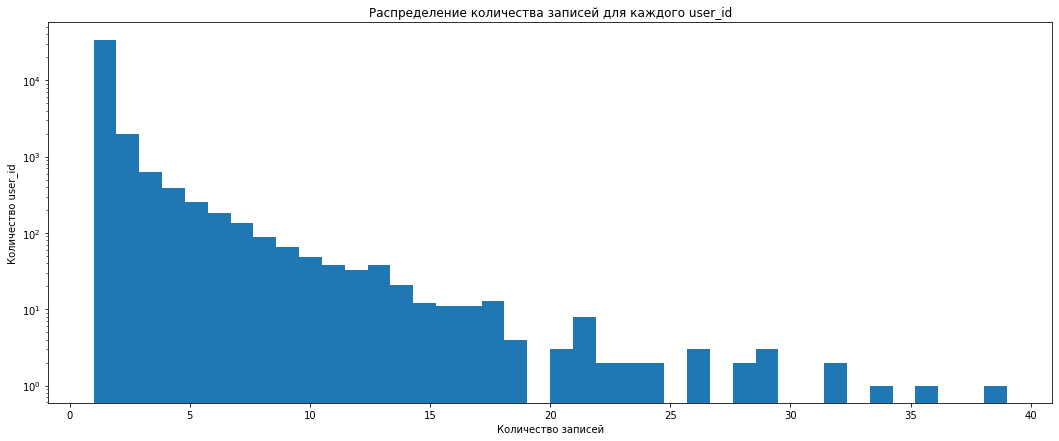

In [80]:
# Получаем распределение количества записей для каждого 'user_id'
user_counts = df['user_id'].value_counts()

# Строим график распределения
plt.figure(figsize=(18, 7))
user_counts[user_counts <= 40].plot(kind='hist', bins=40)  
# Или можно использовать kind='bar' для построения гистограммы столбцов
# Установка логарифмической шкалы по оси Y
plt.yscale('log')
# Настройки графика
plt.xlabel('Количество записей')
plt.ylabel('Количество user_id')
plt.title('Распределение количества записей для каждого user_id')

# Отображение графика
plt.show()

In [81]:
for i in range(1, 52):
    print(f'Количество посещений: {i:2}, количество строк: {user_counts[user_counts == i].count()}')

Количество посещений:  1, количество строк: 34259
Количество посещений:  2, количество строк: 1991
Количество посещений:  3, количество строк: 637
Количество посещений:  4, количество строк: 385
Количество посещений:  5, количество строк: 256
Количество посещений:  6, количество строк: 181
Количество посещений:  7, количество строк: 133
Количество посещений:  8, количество строк: 89
Количество посещений:  9, количество строк: 66
Количество посещений: 10, количество строк: 49
Количество посещений: 11, количество строк: 38
Количество посещений: 12, количество строк: 33
Количество посещений: 13, количество строк: 38
Количество посещений: 14, количество строк: 21
Количество посещений: 15, количество строк: 12
Количество посещений: 16, количество строк: 11
Количество посещений: 17, количество строк: 11
Количество посещений: 18, количество строк: 13
Количество посещений: 19, количество строк: 4
Количество посещений: 20, количество строк: 3
Количество посещений: 21, количество строк: 8
Количе

In [82]:
user_counts[user_counts > 50].count()

0

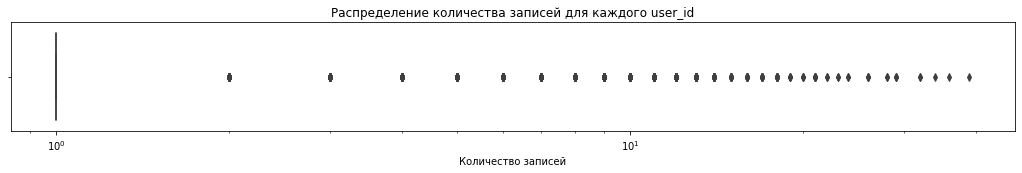

In [83]:
# Получаем распределение количества записей для каждого 'user_id'
user_counts = df['user_id'].value_counts()

# Строим график box plot
plt.figure(figsize=(18, 2))
sns.boxplot(x=user_counts)

# Настройки графика
plt.xscale('log')
plt.xlabel('Количество записей')
plt.title('Распределение количества записей для каждого user_id')

# Отображение графика
plt.show()

In [84]:
# Добавляем колонку 'record_count' с количеством записей для каждого 'user_id'
df['record_count'] = df.groupby('user_id')['bid_ip'].transform('count')
        
# Выводим результат
df.head(7)

,index,bid_url,bid_referer,bid_ip,bid_isp_name,landing_page,page_language,ssp_event_id,ssp,tag_id,publisher_id,creative_size,creative_type,battr,floor_cpm,visibility,carrier_id,model,mobile_screen_size,screen_pixel_ratio,is_https,ibv_blocked,is_interstitial,content_category,mime_types,content_tags,iframe_state,ads_txt_support,historical_viewability,gdpr_regulation,do_not_track,full_placement_id,user_fraud_state,is_mobile_optimized_site,device_screen,advertiser_id,creative_id,timezone_offset,utm_source,search_engine,search_terms,user_segments,time,region_code,city,zip_code,isp_type,user_id,user_detection_type,ud_cookie_ts,accept_encoding,accept_language,ua_device_type,ua_os,ua_browser,ua_third_party_cookie,ua_os_version,ua_browser_version,ua_parsing_type,ua_type,user_status,ct72,ct73,time_diff,label,known,unique_id,record_count
18234,18234,https://house-doc.ru/4-sezon-7-serija-a,None,307ae90192b23d5d4396b4ba049f0531,Beeline Home,https://www.mvideo.ru/?utm_source=getintentdyn...,ru,erKhVX7MKJb,umg,c9447b13c9bfccd2,45,728x90,1,None,0.029120,UNKNOWN,beeline home,NTH-NX9,None,0.0,True,False,False,"iab1,iab1-5","application/javascript,image/jpeg,image/gif,im...",72,2,-2,NaN,-1,0.0,umg_45_1808807699_c9447b13c9bfccd2,2,1.0,None,12453,651853,180.0,None,None,None,"48085,44655,44985,18667,18601,44127,40334,5210...",2024-01-19 19:38:17,77,Moskva,104015,0.0,001RAHXC1O5,3,NaT,None,None,SMARTPHONE,ANDROID,CHROME,True,13,120.0.6099.230,0,3,1,1,0,-999,0,1,307ae90192b23d5d4396b4ba049f0531_beeline home_...,2
29996,29996,https://house-doc.ru/4-sezon-8-serija-a,None,307ae90192b23d5d4396b4ba049f0531,Beeline Home,https://www.mvideo.ru/?utm_source=getintentdyn...,ru,uxbDG7TJohhw,umg,4b74eb47b671700b,87,728x90,1,None,0.011200,UNKNOWN,beeline home,-1,None,0.0,True,False,False,iab24,"application/javascript,image/jpeg,image/gif,im...",72,2,-2,NaN,0,0.0,umg_87_2821977_4b74eb47b671700b,2,1.0,None,12453,651853,180.0,None,None,None,"48085,44655,44985,18667,18601,44127,40334,5210...",2024-01-19 21:49:25,77,Moskva,104015,0.0,001RAHXC1O5,3,NaT,None,None,SMARTPHONE,ANDROID,CHROME,True,13,120.0.6099.230,0,3,1,1,0,-999,0,1,307ae90192b23d5d4396b4ba049f0531_beeline home_...,2
26792,26792,https://mobilegadjet.ru/,None,5a421e204ddac0ce87238e7f70c0bb07,OOO Trivon Networks,https://www.mvideo.ru/?utm_source=getintentdyn...,ru,MsZhdNi2VKR,otm_display,53024,5937c422f0b37c7566937953,336x280,1,None,1.428571,UNKNOWN,ooo trivon networks,-1,None,0.0,True,False,False,iab9,None,72,2,-2,NaN,-1,NaN,otm_display_5937c422f0b37c7566937953_8611_53024,2,NaN,None,12453,651857,180.0,None,None,None,"44474,44820,15550,44622,2094,40318,44589,1039,...",2024-01-10 22:14:58,77,Khimki,141406,0.0,001W4Q0dkit,3,NaT,None,None,DESKTOP,WINDOWS,CHROME,True,10,120.0.0.0,0,1,1,1,0,-999,0,1,5a421e204ddac0ce87238e7f70c0bb07_ooo trivon ne...,1
2793,2793,https://audioknigi.fun/,None,efd8b8789294ccb704ffb196318cc8b8,ER-Telecom,https://incanto.eu/actions/promo/?utm_source=g...,None,PzYGSQmcaoC,otm_display,51337,5937c422f0b37c7566937953,300x250,0,None,1.428571,UNKNOWN,er-telecom,-1,None,0.0,True,False,False,iab9,None,72,2,-2,NaN,-1,NaN,otm_display_5937c422f0b37c7566937953_9005_51337,2,NaN,None,11527,657714,180.0,None,None,None,"36655,36651,53743,46910,36653,53762,36633,5359...",2024-01-14 04:20:08,78,Sankt-Peterburg,190121,0.0,001miiTESZy,3,NaT,None,None,DESKTOP,WINDOWS,OPERA,True,8.1,95.0.0.0,0,1,1,1,0,-999,0,1,efd8b8789294ccb704ffb196318cc8b8_er-telecom_-1...,1
42939,42939,https://audioknigi.pro/,None,c65eb28959318061abf399dddc0fa37c,Cifra1,https://incanto.eu/catalog/basic/?utm_source=g...,None,eM9zpc2i0sN,otm_display,53339,5937c422f0b37c7566937953,300x250,0,None,1.428571,UNKNOWN,cifra1,-1,None,0.0,True,False,False,iab17,None,72,2,-2,NaN,-1,NaN,otm_display_5937c422f0b37c7566937953_9466_53339,2,NaN,None,11527,657558,180.0,None,None,None,"52661,2094,16564,34373,36633,43896,44763,44679...",2024-01-19 22:14:18,77,Moskva,127641,0.0,008XPXgeIos,3,NaT,None,None,SMARTPHONE,ANDROID,CHROME,True,10,120.0.0.0,0,3,1,1,0,-

In [85]:
users1 = df[df.label==1].user_id.unique()
# df[df.user_id.isin(users1)].to_csv('df_label_1.csv', sep=';')
df[df.user_id.isin(users1)]

,index,bid_url,bid_referer,bid_ip,bid_isp_name,landing_page,page_language,ssp_event_id,ssp,tag_id,publisher_id,creative_size,creative_type,battr,floor_cpm,visibility,carrier_id,model,mobile_screen_size,screen_pixel_ratio,is_https,ibv_blocked,is_interstitial,content_category,mime_types,content_tags,iframe_state,ads_txt_support,historical_viewability,gdpr_regulation,do_not_track,full_placement_id,user_fraud_state,is_mobile_optimized_site,device_screen,advertiser_id,creative_id,timezone_offset,utm_source,search_engine,search_terms,user_segments,time,region_code,city,zip_code,isp_type,user_id,user_detection_type,ud_cookie_ts,accept_encoding,accept_language,ua_device_type,ua_os,ua_browser,ua_third_party_cookie,ua_os_version,ua_browser_version,ua_parsing_type,ua_type,user_status,ct72,ct73,time_diff,label,known,unique_id,record_count
26778,26778,https://steamshared.ru/,None,6e09169afc1714d46ece8b1d1d9fdd49,Rostelecom,https://www.mvideo.ru/?utm_source=getintentdyn...,ru,uxA8FMxGgt58,yandex_hb,215_Q6_steamshared.ru_M_inread_300x250,215,300x250,1,None,0.000000,UNKNOWN,rostelecom,-1,None,0.0,True,False,False,iab24,None,"72,73",2,-2,NaN,-1,NaN,215_unknown_215_Q6_steamshared.ru_M_inread_300...,2,NaN,None,12453,651855,180.0,None,None,None,"44820,18568,53362,43896,40335,44128,18799,4465...",2024-01-22 18:56:18,77,Moskva,104015,0.0,0SOICEhdINX,1,2023-10-16 20:57:46,"gzip, deflate, br","ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7",SMARTPHONE,ANDROID,CHROME,True,10,120.0.0.0,0,3,1,1,1,8459912,0,1,6e09169afc1714d46ece8b1d1d9fdd49_rostelecom_-1...,2
30722,30722,https://www.xgamers.ru/article/red-dead-redemp...,None,6e09169afc1714d46ece8b1d1d9fdd49,Rostelecom,https://www.mvideo.ru/?utm_source=getintentdyn...,ru,u8N5MLI8B940,buzzoola,1237440,16381,300x250,1,None,18.000000,UNKNOWN,rostelecom,K,None,0.0,True,False,False,iab24,None,"72,73",2,-2,80.0,-1,NaN,buzzoola_16381_579858_1237440,2,NaN,None,12453,651855,180.0,None,None,None,"51267,44820,43896,18568,53362,44243,44902,4480...",2024-01-22 18:57:02,77,Moskva,104015,0.0,0SOICEhdINX,3,NaT,None,None,SMARTPHONE,ANDROID,CHROME,True,10,120.0.0.0,0,3,1,1,1,-999,1,1,6e09169afc1714d46ece8b1d1d9fdd49_rostelecom_K_...,2
37645,37645,https://irecommend.ru/content/ochen-krasivaya-...,None,efb2e419f4ca80d822cec8cb32cb2de9,ER-Telecom,https://incanto.eu/?utm_source=getintent&utm_m...,ru,uxw11drYbmAy,yandex_hb,120_desktop_sidebar_sticky_300x600,120,300x250,1,None,0.000000,UNKNOWN,er-telecom,-1,None,0.0,True,False,False,iab24,None,72,2,-2,NaN,-1,NaN,120_unknown_120_desktop_sidebar_sticky_300x600,2,NaN,None,11527,657909,420.0,None,None,None,"44655,44622,53560,1056,51878,51877,51415,52967...",2024-01-03 11:39:47,70,Seversk,636035,0.0,6QXz9JrP3fX,1,2023-12-11 05:28:38,"gzip, deflate, br","ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7,uk;q=0.6,g...",DESKTOP,WINDOWS,CHROME,True,10,120.0.0.0,0,1,1,1,0,2009469,0,1,efb2e419f4ca80d822cec8cb32cb2de9_er-telecom_-1...,6
3904,3904,https://irecommend.ru/,None,efb2e419f4ca80d822cec8cb32cb2de9,ER-Telecom,https://incanto.eu/?utm_source=getintent&utm_m...,ru,uPIJYznF1aYZ,yandex_hb,120_desktop_sidebar_sticky_300x600,120,300x600,1,None,0.000000,UNKNOWN,er-telecom,-1,None,0.0,True,False,False,iab24,None,72,2,-2,NaN,-1,NaN,120_unknown_120_desktop_sidebar_sticky_300x600,2,NaN,None,11527,657910,420.0,None,None,None,"44655,44985,53560,1056,52967,44654,16359,47160...",2024-01-11 06:49:17,70,Seversk,636035,0.0,6QXz9JrP3fX,1,2023-12-11 05:28:38,"gzip, deflate, br","ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7,uk;q=0.6,g...",DESKTOP,WINDOWS,CHROME,True,10,120.0.0.0,0,1,1,1,0,2683239,1,1,efb2e419f4ca80d822cec8cb32cb2de9_er-telecom_-1...,6
40618,40618,https://muzofond.fm/,None,efb2e419f4ca80d822cec8cb32cb2de9,ER-Telecom,https://incanto.eu/?utm_source=getintent&utm_m...,ru,u8T2GN02UYd2,sape,94216299,1332979770,300x250,1,None,0.020000,UNKNOWN,er-telecom,Other,None,0.0,True,False,False,iab24,"application/javascript,image/jpeg,image/gif,im...",72,2,-2,82.0,-1,0.0,sape_1332979770_2811701207_94216299,2,NaN,None,11527,657904,420.0,

In [86]:
df[df.user_id.isin(users1)].user_id.value_counts()

6QXz9JrP3fX    6
xH1OmixNcS6    5
0SOICEhdINX    2
Name: user_id, dtype: int64

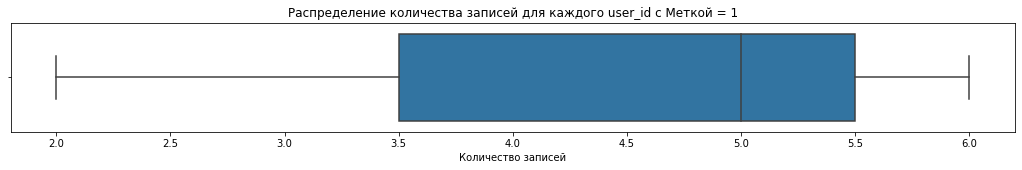

In [87]:
# Получаем распределение количества записей для каждого 'user_id'
user1_counts = df[df.user_id.isin(users1)].user_id.value_counts()

# Строим график box plot
plt.figure(figsize=(18, 2))
sns.boxplot(x=user1_counts)

# Настройки графика
plt.xlabel('Количество записей')
plt.title('Распределение количества записей для каждого user_id c Меткой = 1')

# Отображение графика
plt.show()

In [88]:
# user1_counts.to_csv('user1_counts.csv', sep=';')

In [89]:
train_df = df

In [90]:
def make_groups(row):
    if row.user_id in grp1:
        x = 1
    elif row.user_id in grp2:
        x = 2
    elif row.user_id in grp3:
        x = 3
    else:
        if row.record_count < 30:
            x = row.record_count + 4
        elif row.record_count < 35:
            x = 35
        elif row.record_count < 41:
            x = 41
        elif row.record_count < 51:
            x = 51
        else:
            x = 55
    return x


# Добавляем колонку 'record_count' с количеством записей для каждого 'user_id'
df['record_count'] = df.groupby('user_id')['bid_ip'].transform('count')

# пользователи с меткой и количеством записей
users = df[['user_id', 'label', 'record_count']].drop_duplicates()
users_labels = users[users.label == 1]
grp1 = users_labels[users_labels.record_count < 10].user_id.unique()
grp2 = users_labels[(users_labels.record_count > 9) & (users_labels.record_count < 31) ].user_id.unique()
grp3 = users_labels[users_labels.record_count > 30].user_id.unique()

# Метим группы в зависимости от количества посещений
users['rec_grp'] = users.apply(lambda row: make_groups(row), axis=1)

In [91]:
users_labels

,user_id,label,record_count
30722,0SOICEhdINX,1,2
3904,6QXz9JrP3fX,1,6
47662,xH1OmixNcS6,1,5


In [92]:
users.columns

Index(['user_id', 'label', 'record_count', 'rec_grp'], dtype='object')

In [93]:
stratified = ['label', 'rec_grp']
users['grp_label'] = users.apply(lambda row: '_'.join(str(row[col]) for col in stratified), axis=1)
users.loc[users.user_id.isin(grp1), 'grp_label'] = '1_1'
users.loc[users.user_id.isin(grp2), 'grp_label'] = '1_2'
users.loc[users.user_id.isin(grp3), 'grp_label'] = '1_3'

In [94]:
# users[users.label==1].to_csv('users.csv', sep=';', index=False)
users

,user_id,label,record_count,rec_grp,grp_label
18234,001RAHXC1O5,0,2,6,0_6
26792,001W4Q0dkit,0,1,5,0_5
2793,001miiTESZy,0,1,5,0_5
42939,008XPXgeIos,0,1,5,0_5
39191,009swrBGUnd,0,2,6,0_6
...,...,...,...,...,...
23736,edbbb05c56206a8de8f7ac9d1e996eb0,0,1,5,0_5
34627,97bd3618063e0bc5e298ca45c68bc4ce,0,1,5,0_5
40440,47bec7ec5cf82c4bb897278ca8736375,0,1,5,0_5
32102,0d63a9e779911b427d51c34f068bb16e,0,1,5,0_5


In [95]:
users.grp_label.nunique()

30

In [96]:
users.sort_values('rec_grp').grp_label.unique()

array(['1_1', '0_5', '0_6', '0_7', '0_8', '0_9', '0_10', '0_11', '0_12',
       '0_13', '0_14', '0_15', '0_16', '0_17', '0_18', '0_19', '0_20',
       '0_21', '0_22', '0_23', '0_24', '0_25', '0_26', '0_27', '0_28',
       '0_30', '0_32', '0_33', '0_35', '0_41'], dtype=object)

In [97]:
df.known.value_counts()

1    33502
0    16498
Name: known, dtype: int64

In [98]:
# распределение по пропускам в user_id по количеству записей этого юзера
tmp = df[df.known == 0][['user_id', 'record_count']].drop_duplicates()

In [99]:
tmp.record_count.value_counts(normalize=False)

1    15619
2      370
3       24
4        4
6        4
5        2
9        1
8        1
Name: record_count, dtype: int64

In [100]:
# пропущенные юзеры, которые встретились 1 раз
df[((df.known == 0) & (df.record_count < 2))]

,index,bid_url,bid_referer,bid_ip,bid_isp_name,landing_page,page_language,ssp_event_id,ssp,tag_id,publisher_id,creative_size,creative_type,battr,floor_cpm,visibility,carrier_id,model,mobile_screen_size,screen_pixel_ratio,is_https,ibv_blocked,is_interstitial,content_category,mime_types,content_tags,iframe_state,ads_txt_support,historical_viewability,gdpr_regulation,do_not_track,full_placement_id,user_fraud_state,is_mobile_optimized_site,device_screen,advertiser_id,creative_id,timezone_offset,utm_source,search_engine,search_terms,user_segments,time,region_code,city,zip_code,isp_type,user_id,user_detection_type,ud_cookie_ts,accept_encoding,accept_language,ua_device_type,ua_os,ua_browser,ua_third_party_cookie,ua_os_version,ua_browser_version,ua_parsing_type,ua_type,user_status,ct72,ct73,time_diff,label,known,unique_id,record_count
27081,27081,https://3-hd.lorfil.net/26985-opasnye-sekrety-...,None,822ed98485b940a27fa1709c20a27fa2,Yota,https://incanto.eu/?utm_source=getintent&utm_m...,ru,u6Ygpp3BOkMR,otm_display,27347,bfld062ac88i0cq3hkhg,300x250,1,None,10.937500,UNKNOWN,yota,-1,None,0.0,True,False,False,iab1,None,"72,73",2,-2,NaN,-1,NaN,otm_display_bfld062ac88i0cq3hkhg_5049_27347,4,NaN,None,11527,657904,180.0,None,None,None,None,2024-01-02 21:00:03,-1,-1,-1,0.0,822ed98485b940a27fa1709c20a27fa2,0,NaT,None,None,SMARTPHONE,ANDROID,CHROME,True,10,120.0.0.0,0,3,11,1,1,-999,0,0,822ed98485b940a27fa1709c20a27fa2_yota_-1_-1_-1...,1
16189,16189,https://hd.23lordfilm-0.xyz/14348-rozhdestvens...,None,a1235b11d740576d630787d0c89b2521,PJSC Bashinformsvyaz,https://incanto.eu/actions/chetvertye-trusiki-...,None,uxlmhYJ2eZXy,ohmybid,edc9af5caf212081,102,300x250,0,None,2.133000,UNKNOWN,pjsc bashinformsvyaz,-1,None,0.0,True,False,False,iab19,None,72,2,-2,NaN,-1,NaN,ohmybid_102_9813_edc9af5caf212081,4,0.0,None,11527,657699,300.0,None,None,None,None,2024-01-02 21:00:45,2,Ufa,450511,0.0,a1235b11d740576d630787d0c89b2521,0,NaT,None,None,DESKTOP,WINDOWS,YANDEX,True,10,23.11.3.935,0,1,11,1,0,-999,0,0,a1235b11d740576d630787d0c89b2521_pjsc bashinfo...,1
25931,25931,https://hd.11lordserials.xyz,https://hd.11lordserials.xyz/32-lyupen-w11.html,39557304053ed7638c7a5c94d237577a,MTS PJSC,https://incanto.eu/catalog/eksklyuzivnye_kolle...,None,usNPy7fafWPJ,buzzoola,adfox_169919033343251296~49-Hp4Jz,17153,320x50,0,None,1.000000,UNKNOWN,mts pjsc,SM-M307FN,None,0.0,True,False,False,iab24,None,72,2,-2,80.0,-1,NaN,buzzoola_17153_581660_adfox_169919033343251296...,4,NaN,None,11527,657585,180.0,None,None,None,None,2024-01-02 21:01:13,23,Krasnodar,350000,0.0,39557304053ed7638c7a5c94d237577a,0,NaT,None,None,SMARTPHONE,ANDROID,OTHER,True,11,22.116.1,0,3,11,1,0,-999,0,0,39557304053ed7638c7a5c94d237577a_mts pjsc_SM-M...,1
41432,41432,https://hd.23lordfilm-0.xyz,https://hd.23lordfilm-0.xyz/14019-konec-sveta-...,bb61575bda052eed27bbc87dfd996084,Moscow City Telephone Network,https://incanto.eu/catalog/eksklyuzivnye_kolle...,None,e06dE2ReFX0,buzzoola,adfox_170117408999589808~49-Mb4Yn,17153,300x250,0,None,1.000000,UNKNOWN,moscow city telephone network,Unknown,None,0.0,True,False,False,iab24,None,72,2,-2,80.0,-1,NaN,buzzoola_17153_581660_adfox_170117408999589808...,4,NaN,None,11527,657589,180.0,None,None,None,None,2024-01-02 21:01:17,77,Moskva,104015,0.0,bb61575bda052eed27bbc87dfd996084,0,NaT,None,None,DESKTOP,WINDOWS,EDGE,True,10,120.0.0.0,0,1,11,1,0,-999,0,0,bb61575bda052eed27bbc87dfd996084_moscow city t...,1
35239,35239,http://kinoseriya.pro/russkie-serialy/1415-128...,None,1d5d920acd2f87114110571f2098997d,Beeline,https://incanto.eu/?utm_source=getintent&utm_m...,None,u7hOf8cjFQ5w,ohmybid,3e505bbf6d02b842,102,300x250,1,None,14.927000,UNKNOWN,beeline,-1,None,0.0,True,False,False,iab1,None,"72,73",2,-2,NaN,-1,NaN,ohmybid_102_5049_3e505bbf6d02b842,4,1.0,None,11527,657904,180.0,None,None,None,None,2024-01-02 21:02:37,16,Kazan',422525,0.0,1d5d920acd2f87114110571f2098997d,0,NaT,None,None,SMARTPHONE,ANDROID,CHROME,True,10,120.0.0.0,0,3,11,1,1,-999,0,0,1d5d920acd2f87114110571f2098997d_beel

In [101]:
# Уберем пропущенных юзеров, которые встретились 1 раз
df = df[~((df.known == 0) & (df.record_count < 2))]

In [103]:
# !pip install implicit
# !pip install faiss-cpu

In [ ]:
df.user_segments = df.user_segments.map(lambda x: '' if pd.isna(x) else ' '.join(sorted(x.split(','))))

In [ ]:
df.user_segments = df.user_segments.map(lambda x: '' if pd.isna(x) else ' '.join(sorted(x.split(), key=int)))

In [ ]:
segments = set(' '.join(df.user_segments.to_list()).split())

In [ ]:
df.timezone_offset.mode()[0]

In [ ]:
df.timezone_offset.unique()

In [ ]:
df.timezone_offset.fillna(df.timezone_offset.mode()[0], inplace=True)
df.timezone_offset = (df.timezone_offset / 60).astype(int)

In [ ]:
df['landing_catalog'] = df['landing_page'].str.replace('&utm_term=.*', '',
                                                       regex=True,
                                                       flags=re.DOTALL)
df['host'] = df['landing_page'].str.split('/').str[2]

In [ ]:
df[['host', 'landing_catalog']]

In [ ]:
# добавление информации по third_party_conversions
df = df.merge(conv_info, on='user_id', how='left').fillna(0)

In [ ]:
stop_run

In [ ]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

# стратификация

In [ ]:
# вариант разбиения по юзерам без фолдов
test_size = 0.4

U_train, U_valid = train_test_split(users, test_size=test_size,
                                    random_state=SEED,
                                    stratify=users.grp_label)

X_train = train_df[train_df.user_id.isin(U_train.user_id)]
y_train = X_train.label
X_train.drop(['time', 'label'], axis=1, inplace=True)

X_valid = train_df[train_df.user_id.isin(U_valid.user_id)]
y_valid = X_valid.label
X_valid.drop(['time', 'label'], axis=1, inplace=True)
#
real_size = round(X_valid.shape[0] / train_df.shape[0], 2)
test_size = f'{test_size} real_size: {real_size}'

In [ ]:
# стратификация по фолдам
skf = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
skf_folds = skf.split(users, users.grp_label)

In [ ]:
# вариант разбиения по юзерам по фолдам

for idx, (train_idx, valid_idx) in enumerate(skf_folds, 1):
    print(f'Фолд {idx} из {num_folds}')

    X_train = train_df[train_df.user_id.isin(users.iloc[train_idx].user_id)]
    y_train = X_train.label
    X_train.drop(['time', 'label'], axis=1, inplace=True)

    X_valid = train_df[train_df.user_id.isin(users.iloc[valid_idx].user_id)]
    y_valid = X_valid.label
    X_valid.drop(['time', 'label'], axis=1, inplace=True)

    splited = X_train, X_valid, y_train, y_valid

    train_data = Pool(data=X_train, label=y_train, cat_features=cat_features)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_features)

    clf = CatBoostClassifier(**clf_params)
    clf.fit(train_data, eval_set=valid_data, use_best_model=True, verbose=100)

    models.append(clf)


In [73]:
# cols = ['ssp_event_id', 'conversion_name', 'is_post_click']
cols = ['ssp_event_id', 'is_post_click']
df = train_views.merge(train_actions[cols], how='left', on='ssp_event_id')
df.is_post_click.fillna(0, inplace=True)
df.rename(columns={'is_post_click': 'label'}, inplace=True)
df.label = df.label.astype(int)
df.drop_duplicates(inplace=True)

time: 15.1 s (started: 2024-03-24 22:05:42 +03:00)


In [74]:
df['landing_catalog'] = df['landing_page'].str.replace('&utm_term=.*', '',
                                                       regex=True,
                                                       flags=re.DOTALL)
df['creative_size_height'] = df['creative_size'].str.split('x').str[0].astype(int)
df['creative_size_width'] = df['creative_size'].str.split('x').str[1].astype(int)
df['full_placement_id2'] = df['full_placement_id'].str.split('_').str[0]
df['host'] = df['landing_page'].str.split('/').str[2]

time: 13.8 s (started: 2024-03-24 22:06:43 +03:00)


In [75]:
df.ssp_event_id.value_counts()

ssp_event_id
u60R6nMXDTyb    4
87LcBeZN3tV     4
ex4dGf3sYXK     4
ghFsve5Hf2U     4
eRECqvAhyTX     4
               ..
uPbrelApgkUq    1
u5XjFeDLbWmf    1
0mOfVW9o7qV     1
7AlYUfnI7f7     1
eE7AzOd01CG     1
Name: count, Length: 1502746, dtype: int64

time: 1.33 s (started: 2024-03-24 22:07:00 +03:00)


In [86]:
users1 = df[df.label==1].user_id.values
users1

array(['6QXz9JrP3fX', '0SOICEhdINX', 'xH1OmixNcS6', 'xH1OmixNcS6',
       'xH1OmixNcS6', 'xH1OmixNcS6', '6tpDnVzkYjV', '6tpDnVzkYjV',
       '6tpDnVzkYjV', '6tpDnVzkYjV', 'u5w3pD8Kx7VN', 'u5w3pD8Kx7VN',
       'uQ6IlCPfROt', 'uQ6IlCPfROt', 'uQ6IlCPfROt', 'uQ6IlCPfROt',
       'uQ6IlCPfROt', 'uQ6IlCPfROt', 'uQ6IlCPfROt', 'uQ6IlCPfROt',
       'uQ6IlCPfROt', 'uMBatiWrb4n', 'u5jKwSOVceM0', 'u5jKwSOVceM0',
       'u5jKwSOVceM0', 'u5jKwSOVceM0', 'u5jKwSOVceM0', 'u7PXB6rb8p94',
       'gZBFgMvWHoO', 'gZBFgMvWHoO', 'gZBFgMvWHoO', 'gZBFgMvWHoO',
       'u6SaV0Is5ebR', 'LxCdkvaDv1o', 'LxCdkvaDv1o', 'LxCdkvaDv1o',
       '7qL15sWPSH4', '7qL15sWPSH4', 'eYDbGaQCibb', 'eYDbGaQCibb',
       'eYDbGaQCibb', 'uPqRQJOxjn9I', '0KqD2bOMy22', 'u6ik0W3NoMtt',
       'u0AjLyAJXZm0', 'u6YAwIMTfh7L', '78QBKLjDnt3', 'usY3AxL9gl8S',
       'u76a5xYvHy7a', 'u76a5xYvHy7a', 'u8MlD7dQEeQG', 'u86PASIGdjNi',
       'ux13KBSLa6nG', 'ux13KBSLa6nG', 'ux13KBSLa6nG', '6vVhaaFzBJr',
       '6vVhaaFzBJr', '6vVhaaFzBJr', '0Gc

time: 31 ms (started: 2024-03-24 22:50:44 +03:00)


In [87]:
df[df.user_id.isin(users1)].user_id.value_counts()

user_id
uM65NrbDebyE    954
exMWs0vOMak     697
uMJDPAPBfHJ6    607
uss2RQNtpmaP    474
P8JbNOySB86     455
               ... 
u6ik0W3NoMtt      2
uLmEAVpcxLnS      2
u5VrF91wJgvK      1
uMoIw5smQ2ES      1
u8MlD7dQEeQG      1
Name: count, Length: 102, dtype: int64

time: 109 ms (started: 2024-03-24 22:50:44 +03:00)


In [88]:
df[df.user_id.isin(users1)].to_excel('users1_2.xlsx')

time: 12.4 s (started: 2024-03-24 22:50:44 +03:00)


In [178]:
df = pd.read_excel('users1_2.xlsx', index_col=0)
df.sample(7)

,bid_url,bid_referer,bid_ip,bid_isp_name,landing_page,page_language,ssp_event_id,ssp,tag_id,publisher_id,creative_size,creative_type,battr,floor_cpm,visibility,carrier_id,model,mobile_screen_size,screen_pixel_ratio,is_https,ibv_blocked,is_interstitial,content_category,mime_types,content_tags,iframe_state,ads_txt_support,historical_viewability,gdpr_regulation,do_not_track,full_placement_id,user_fraud_state,is_mobile_optimized_site,device_screen,advertiser_id,creative_id,timezone_offset,utm_source,search_engine,search_terms,user_segments,time,region_code,city,zip_code,isp_type,user_id,user_detection_type,ud_cookie_ts,accept_encoding,accept_language,ua_device_type,ua_os,ua_browser,ua_third_party_cookie,ua_os_version,ua_browser_version,ua_parsing_type,ua_type,user_status,ct72,ct73,time_diff,conversion_name,label,landing_catalog,creative_size_height,creative_size_width,full_placement_id2,host
1953203,https://mixnews.lv/znaki-zodiaka/2024/01/08/re...,NaN,d70b03fbddb9b44978ee3711fd3ff0b7,JSC Ufanet,https://incanto.eu/?utm_source=getintent&utm_m...,NaN,8Pk5No3X5nQ,ohmybid,e668b75271b57751,88,300x250,1,NaN,0.218000,UNKNOWN,jsc ufanet,Other,NaN,0,True,False,False,iab24,NaN,72,0,-2,NaN,0,NaN,ohmybid_88_633106_e668b75271b57751,2,1.0,NaN,11527,657909,300,NaN,NaN,NaN,"44721,53560,18469,52966,18667,18601,44127,4412...",2024-01-08 18:11:52,2.0,Ufa,450511.0,0.0,ueYrBaWgiABd,3,NaT,NaN,NaN,SMARTPHONE,ANDROID,CHROME,True,10.0,120.0.0.0,0,3,1,1,0,-999,NaN,0,https://incanto.eu/?utm_source=getintent&utm_m...,300,250,ohmybid,incanto.eu
765321,https://ngs24.ru/text/incidents/2024/01/11/731...,NaN,91f2f6f5cd4c89da9e70eb10f2875a2c,CryptoCentre LLC,https://incanto.eu/?utm_source=getintent&utm_m...,ru,u6lvhnDwoSST,btw,3864734,40405,300x600,1,NaN,4.071429,UNKNOWN,cryptocentre llc,Linux Desktop,NaN,1,True,False,False,iab24,NaN,72,0,1,50.0,0,NaN,btw_40405_601059_3864734,2,NaN,NaN,11527,657910,420,NaN,NaN,NaN,"44523,44655,44985,43006,44589,53560,44127,4412...",2024-01-11 07:12:52,24.0,Krasnoyarsk,660000.0,0.0,7p9dv9X1pfT,3,NaT,NaN,NaN,DESKTOP,LINUX,OTHER,True,NaN,106.0.5249.12,0,1,1,1,0,-999,NaN,0,https://incanto.eu/?utm_source=getintent&utm_m...,300,600,btw,incanto.eu
549879,https://e.mail.ru/,NaN,c5ad109fe95f7b3f76d4c0fd3b4887b8,Rostelecom,https://incanto.eu/?utm_source=getintent&utm_m...,ru,e0ATvBSIlaQ,sape,3884814253,4274747635,240x400,1,NaN,25.000000,UNKNOWN,rostelecom,Other,NaN,0,True,False,False,iab24,NaN,72,2,-2,69.0,-1,NaN,sape_4274747635_4274747635_3884814253,2,NaN,NaN,11527,657908,600,NaN,NaN,NaN,"44655,44820,44985,44622,53395,18601,53362,4389...",2024-01-15 02:04:23,25.0,Vladivostok,690066.0,0.0,uM65NrbDebyE,3,NaT,NaN,NaN,DESKTOP,WINDOWS,CHROME,True,10.0,120.0.0.0,0,1,1,1,0,-999,NaN,0,https://incanto.eu/?utm_source=getintent&utm_m...,240,400,sape,incanto.eu
731668,https://e.mail.ru/,NaN,c66277483502799049a6ff879b744861,Ooo necstel,https://incanto.eu/?utm_source=getintent&utm_m...,ru,u7FZUcByd7Xp,buzzoola,948435,17427,240x400,1,NaN,29.000000,UNKNOWN,ooo necstel,Unknown,NaN,0,True,False,False,iab24,NaN,72,2,-2,80.0,-1,NaN,buzzoola_17427_583156_948435,2,NaN,NaN,11527,657908,180,NaN,NaN,NaN,"52999,44820,43896,44128,51483,53625,44620,4488...",2024-01-22 07:35:58,77.0,Moskva,104015.0,0.0,xkawp1eZt9s,3,NaT,NaN,NaN,DESKTOP,WINDOWS,CHROME,True,10.0,120.0.0.0,0,1,1,1,0,-999,NaN,0,https://incanto.eu/?utm_source=getintent&utm_m...,240,400,buzzoola,incanto.eu
1867858,https://w15.fullsee.site/,NaN,306c6810a656d661d8f676526eff5d5f,Svyaz-Energo Ltd.,https://incanto.eu/?utm_source=getintent&utm_m...,NaN,eV9UOTIqBnw,solta,1222537,8881,300x250,1,NaN,93.600000,UNKNOWN,svyaz-energo ltd.,M2006C3MNG,NaN,0,True,False,False,iab1-5,"image/jpg,application/javascript,image/jpeg,im...",72,2,-2,NaN,-1,NaN,solta_8881_576810_1222537,2,NaN,NaN,11527,657904,180,NaN,NaN,NaN,"44655,51482,52867,44622,52109,40335,44656,5148...",2024-01-03 07:16:28,44.0,Shar'ya,157500.0,0.0,LY8hKvrpGcT,3,NaT,NaN,NaN,SMARTPHONE,ANDROID,CHROME,True,10.0,120.0.0.0,0,3,1,1,0,-999,NaN,0,https://incanto.eu/?

In [160]:
df.shape

(13636, 70)

In [161]:
df.columns

Index(['bid_url', 'bid_referer', 'bid_ip', 'bid_isp_name', 'landing_page',
       'page_language', 'ssp_event_id', 'ssp', 'tag_id', 'publisher_id',
       'creative_size', 'creative_type', 'battr', 'floor_cpm', 'visibility',
       'carrier_id', 'model', 'mobile_screen_size', 'screen_pixel_ratio',
       'is_https', 'ibv_blocked', 'is_interstitial', 'content_category',
       'mime_types', 'content_tags', 'iframe_state', 'ads_txt_support',
       'historical_viewability', 'gdpr_regulation', 'do_not_track',
       'full_placement_id', 'user_fraud_state', 'is_mobile_optimized_site',
       'device_screen', 'advertiser_id', 'creative_id', 'timezone_offset',
       'utm_source', 'search_engine', 'search_terms', 'user_segments', 'time',
       'region_code', 'city', 'zip_code', 'isp_type', 'user_id',
       'user_detection_type', 'ud_cookie_ts', 'accept_encoding',
       'accept_language', 'ua_device_type', 'ua_os', 'ua_browser',
       'ua_third_party_cookie', 'ua_os_version', 'ua_browser_

In [186]:
# Получение количества записей одного события. В качестве второго поля группировки
# можно взять любое из полей landing_page, ssp_event_id, time - они одинаковые
# в пределах одного события
df['event_cnt'] = df.groupby(['user_id', 'landing_page'])['bid_ip'].transform('count').fillna(0)
shift_back, shift_forw = [], []
for step in range(-13, 14):
    col = f'S_{step}'
    if step:
        df[col] = (df['landing_page'] == df['landing_page'].shift(step)).astype(int)
    if step < 0:
        shift_forw.append(col)
    if step > 0:
        shift_back.append(col)
        
df['event_back'] = df[shift_back].sum(axis=1)
df['event_forw'] = df[shift_forw].sum(axis=1)
df['event_rows'] = df[['event_back', 'event_forw']].max(axis=1)
df['diff_back'] = df['event_cnt'] - df['event_back']
df['diff_forw'] = df['event_cnt'] - df['event_forw']
df['diff_rows'] = df['event_cnt'] - df['event_rows'] - 1

# df.drop(['event_back', 'event_forw', 'diff_back', 'diff_forw'], axis=1, inplace=True)

# Возможно колонки shift_cols нужно удалить из ДФ

In [187]:
use_cols = ['user_id', 'landing_page', 'ssp_event_id', 'time', 'conversion_name', 'label', 'event_cnt', 
            'event_back', 'event_forw', 'event_rows', 'diff_back', 'diff_forw', 'diff_rows']
df[use_cols + shift_cols].to_excel('users1_3.xlsx')

In [188]:
df.event_cnt.value_counts()

1     12283
7       252
8       216
10      190
6       168
5       150
4       124
9       108
3        87
2        24
11       22
12       12
Name: event_cnt, dtype: int64

In [189]:
df.event_rows.value_counts()

0     12283
4       254
5       246
3       214
6       194
2       150
7       122
8        68
1        53
9        44
10        6
11        2
Name: event_rows, dtype: int64

In [190]:
df[(df.conversion_name=='cart') & (df.label==1)].event_rows.value_counts()

5     34
6     18
4     15
3     14
7     14
9      3
2      3
1      3
8      2
10     1
Name: event_rows, dtype: int64